In [1]:
from copy import deepcopy
import os
import sys
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd

from scipy.optimize import basinhopping, minimize
from scipy.stats import chisquare

sys.path.append(os.path.dirname(sys.path[0]))

In [3]:
from rmo import RadialMovementOptimization
import scripts.constants as con
from scripts.helpers import get_unique_frame
from scripts.plotter import Plotter, get_temperature_legend
from scripts.properties.ovito_procedures import OvitoProcessor

from scripts.rdf_calculator import RDFCalculator

In [4]:
np.random.seed(0)

In [5]:
@njit
def math_round(value):
    rest = value - int(value)
    if rest >= 0.5 and value >= 0:
        return float(int(value) + 1)
    if rest <= -0.5 and value < 0:
        return float(int(value) - 1)
    return float(int(value))

@njit
def get_boundary_conditions(
        cell_dimensions: np.ndarray,
        particles_number: int,
        positions: np.ndarray,
):
    for i in range(particles_number):
        for j in range(3):
            if positions[i][j] >= cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
            if positions[i][j] < -cell_dimensions[j] / 2.0:
                positions[i][j] -= (
                        math_round(positions[i][j] / cell_dimensions[j])
                        * cell_dimensions[j]
                )
    return positions

In [6]:
def calculate_rdf(positions):
    cell_dimensions = np.array([12.25, 12.25, 12.25])
    radii, rdf = OvitoProcessor(
        positions=positions, 
        cell_dimensions=cell_dimensions,
    ).get_rdf()
    return radii, rdf

In [7]:
def mse(obs, exp):
    return np.sum((obs - exp) ** 2)

In [8]:
def generate_random_state() -> None:
    particles_number = 1372
    cell_dimensions = 12.25 * np.ones(3)
    return (np.random.random((particles_number, 3)) - 0.5) * cell_dimensions

In [9]:
CURRENT_DATA_NORMAL = '2021-09-24_prepared_1.3_normal'
PLOT_FILENAME_POSTFIX_NORMAL = 'rmo'

PATH_TO_CURRENT_DATA_NORMAL = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_NORMAL)
PATH_TO_PLOTS = os.path.join(con.PATH_TO_PLOTS, CURRENT_DATA_NORMAL)

PATH_TO_CURRENT_DATA_NORMAL

'D:\\albert\\programming\\git_reps\\molecular_dynamics\\data\\2021-09-24_prepared_1.3_normal'

In [10]:
samples = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'samples.npy'))
test_sample = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'test_sample.npy'))
targets = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'targets_pbc.npy'))
cooled_1 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_1.npy'))
cooled_2 = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'cooled_2.npy'))

samples.shape, test_sample.shape, targets.shape, cooled_1.shape, cooled_2.shape

((2464, 612), (1, 612), (2464, 1372, 3), (1372, 3), (1372, 3))

In [11]:
i = 1
some_positions = targets[-i]

obs_rdf = calculate_rdf(targets[i])[1]

some_positions.shape

(1372, 3)

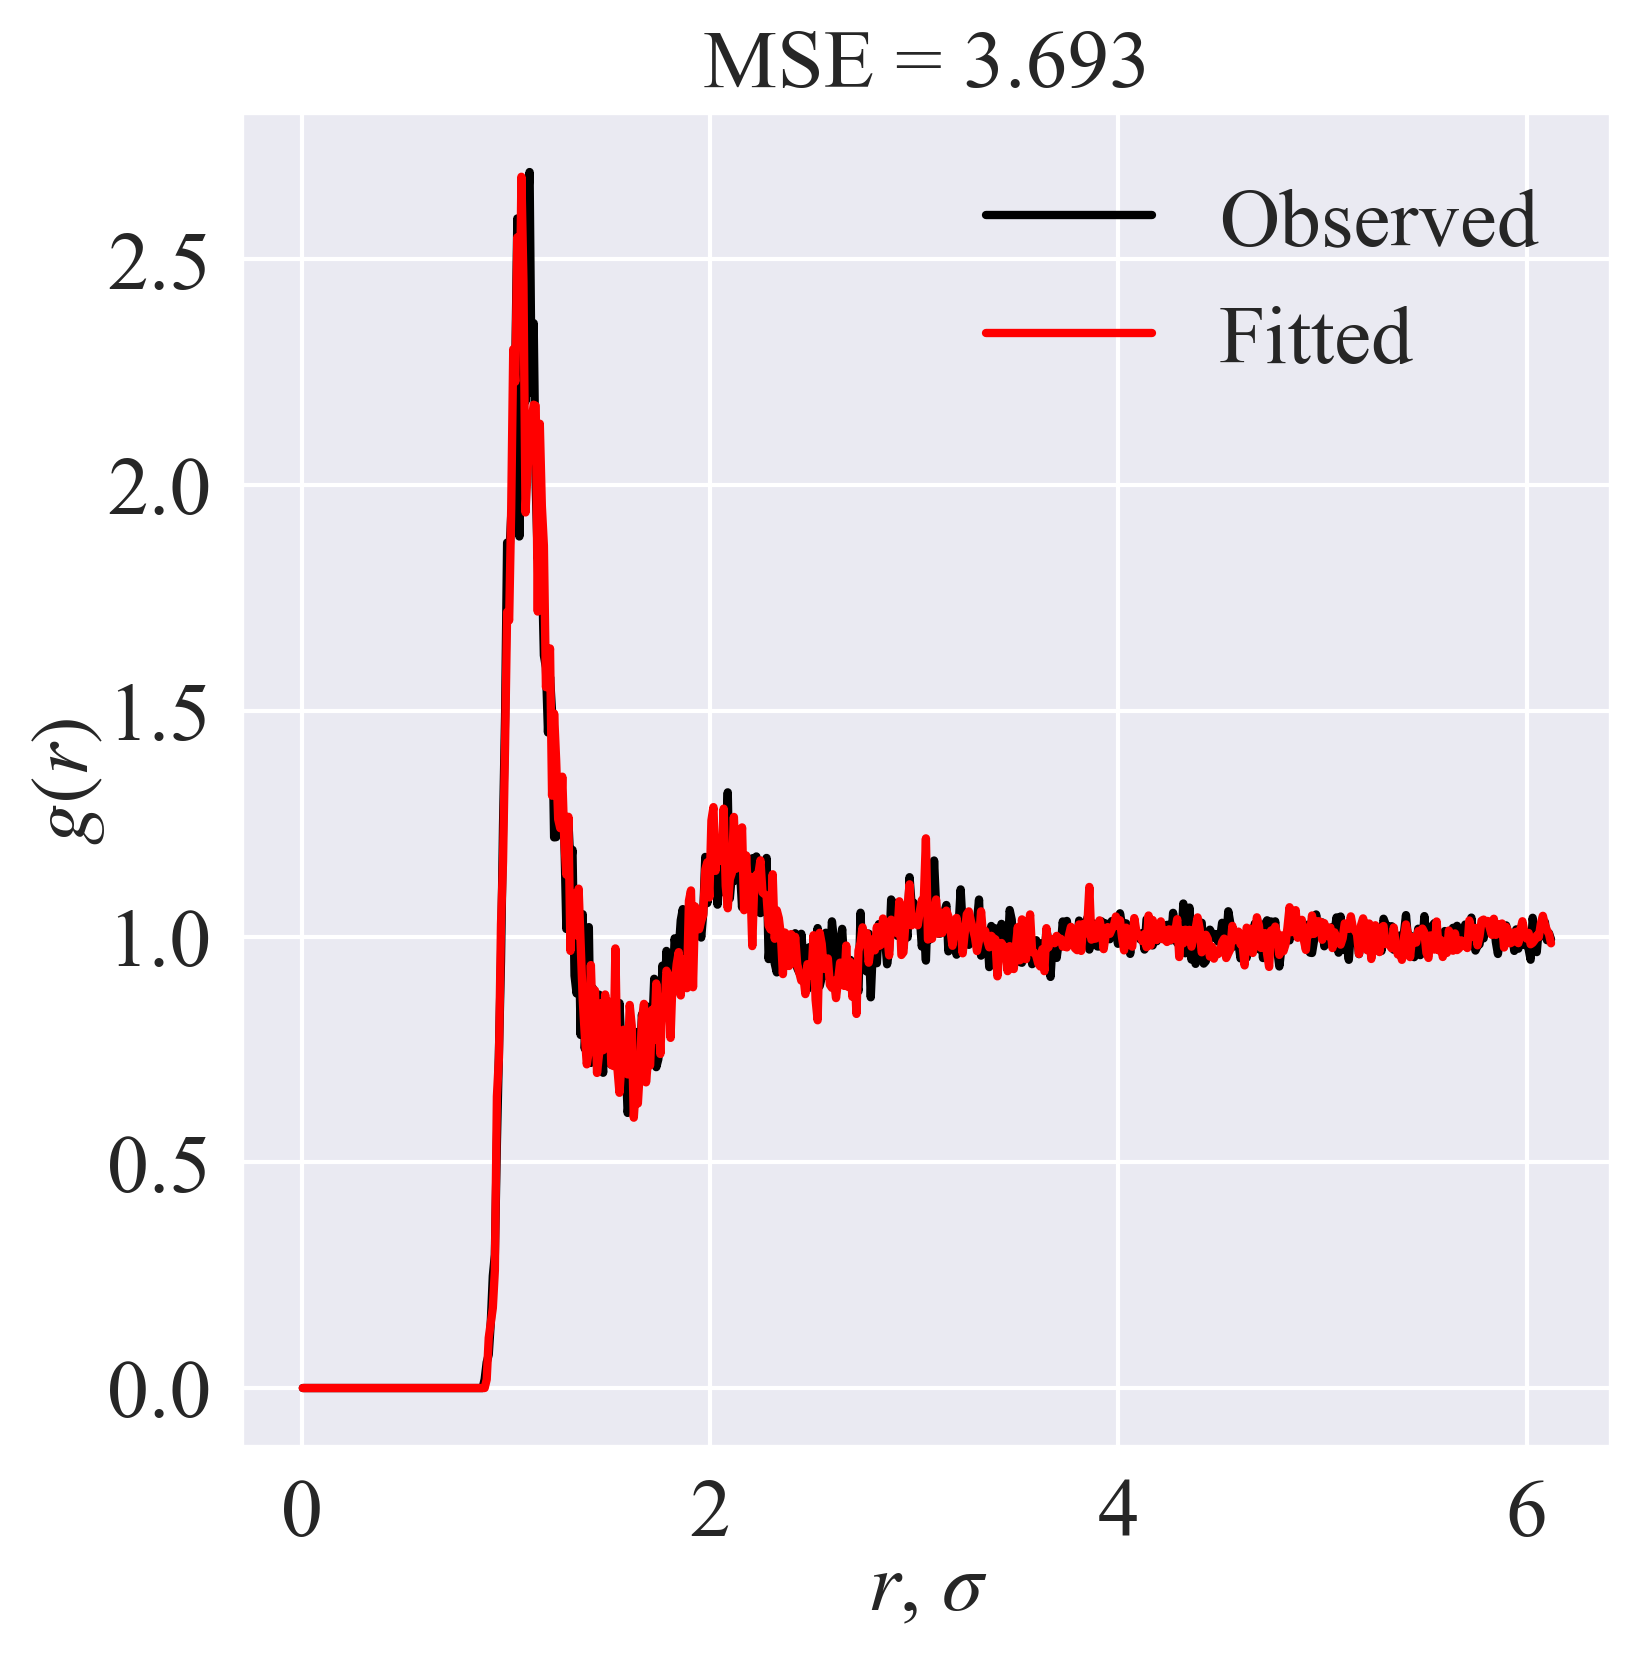

In [12]:
radii, exp_rdf = calculate_rdf(np.array(some_positions))
size = obs_rdf.size
radii = radii[:size]
exp_rdf = exp_rdf[:size]

plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, exp_rdf, color='red', label='Fitted')
plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=exp_rdf):.3f}')
plotter.get_legend()
plotter.save_plot('initial_state_local.png')
plt.show()

In [13]:
cell_dimensions = np.ones(3) * 12.25

In [14]:
def optimized_func(positions):
    collided_number = 0
    positions = positions.reshape(1372, 3)
    radii, exp_rdf = calculate_rdf(positions)
    size = obs_rdf.size
    radii = radii[:size]
    exp_rdf = exp_rdf[:size]
    if np.where(exp_rdf > 0)[0][0] < np.where(obs_rdf > 0)[0][0]:
        collided_number = exp_rdf[np.where(exp_rdf > 0)[0]].sum()
    result = mse(obs=obs_rdf, exp=exp_rdf)
    return result, collided_number

In [15]:
def interruption_proof_rmo(args, function, generations_number, particles_number, c_parameters, scale, weight_limits):
    outer_start = datetime.now()
    flattened = np.array(args).flatten()
    rmo_instance = RadialMovementOptimization(
        generations_number=generations_number,
        particles_number=particles_number,
        dimensions_number=flattened.size,
        bounds=(-cell_dimensions[0] / 2, cell_dimensions[0] / 2),
        centre=flattened,
    )
    try:
        rmo_instance.optimize(
            func=function,
            c_parameters=c_parameters,
            scale=scale,
            weight_limits=weight_limits,
        )
    except (KeyboardInterrupt, SystemError):
        pass
    print(f'{datetime.now() - outer_start = }')
    return rmo_instance.global_best.reshape(args.shape)

In [16]:
new_positions = interruption_proof_rmo(
    args=some_positions,
    function=lambda x: optimized_func(x)[0],
    generations_number=10,
    particles_number=100,
    c_parameters=(0.9, 1.0),
    scale=100,
    weight_limits=(0, 1)
)

global_minimum = 3.69284
gen = 0; gen_min = 3.6928; global = 3.6928; denominator = 100; execution_time = 0:00:12.526995
gen = 1; gen_min = 3.6928; global = 3.6928; denominator = 100; execution_time = 0:00:11.151007
gen = 2; gen_min = 3.6928; global = 3.6928; denominator = 100; execution_time = 0:00:10.652992
gen = 3; gen_min = 3.6928; global = 3.6928; denominator = 100; execution_time = 0:00:12.679992
gen = 4; gen_min = 3.6928; global = 3.6928; denominator = 100; execution_time = 0:00:10.001998
gen = 5; gen_min = 3.5097; global = 3.5097; denominator = 100; execution_time = 0:00:09.782004
gen = 6; gen_min = 3.5097; global = 3.5097; denominator = 100; execution_time = 0:00:09.860994
gen = 7; gen_min = 3.5097; global = 3.5097; denominator = 100; execution_time = 0:00:09.886000
gen = 8; gen_min = 3.5097; global = 3.5097; denominator = 100; execution_time = 0:00:09.836003
gen = 9; gen_min = 3.5097; global = 3.5097; denominator = 100; execution_time = 0:00:10.732997
datetime.now() - outer_st

In [17]:
scale = 100
out = optimized_func(new_positions)[0]

for i in range(50):
    print(f'{i = }')
    new_positions = interruption_proof_rmo(
        args=new_positions,
        function=lambda x: optimized_func(x)[0],
        generations_number=5,
        particles_number=100,
        c_parameters=(0.9, 1.0),
        scale=scale,
        weight_limits=(0, 1)
    )
    new_out = optimized_func(new_positions)[0]
    if new_out == out:
        scale *= 2
    out = new_out

i = 0
global_minimum = 3.50967
gen = 0; gen_min = 3.5097; global = 3.5097; denominator = 100; execution_time = 0:00:10.476073
gen = 1; gen_min = 3.5097; global = 3.5097; denominator = 100; execution_time = 0:00:09.554002
gen = 2; gen_min = 3.5097; global = 3.5097; denominator = 100; execution_time = 0:00:09.538999
gen = 3; gen_min = 3.5097; global = 3.5097; denominator = 100; execution_time = 0:00:09.745001
gen = 4; gen_min = 3.5097; global = 3.5097; denominator = 100; execution_time = 0:00:09.733999
datetime.now() - outer_start = datetime.timedelta(seconds=49, microseconds=149065)
i = 1
global_minimum = 3.50967
gen = 0; gen_min = 3.5097; global = 3.5097; denominator = 200; execution_time = 0:00:09.774000
gen = 1; gen_min = 3.5097; global = 3.5097; denominator = 200; execution_time = 0:00:09.566006
gen = 2; gen_min = 3.5097; global = 3.5097; denominator = 200; execution_time = 0:00:09.782993
gen = 3; gen_min = 3.5097; global = 3.5097; denominator = 200; execution_time = 0:00:09.638000


gen = 0; gen_min = 3.0269; global = 3.0269; denominator = 6400; execution_time = 0:00:09.450999
gen = 1; gen_min = 3.0269; global = 3.0269; denominator = 6400; execution_time = 0:00:09.480000
gen = 2; gen_min = 3.0269; global = 3.0269; denominator = 6400; execution_time = 0:00:09.472999
gen = 3; gen_min = 3.0269; global = 3.0269; denominator = 6400; execution_time = 0:00:09.614000
gen = 4; gen_min = 2.9943; global = 2.9943; denominator = 6400; execution_time = 0:00:10.637000
datetime.now() - outer_start = datetime.timedelta(seconds=48, microseconds=750998)
i = 15
global_minimum = 2.99434
gen = 0; gen_min = 2.9943; global = 2.9943; denominator = 6400; execution_time = 0:00:09.966994
gen = 1; gen_min = 2.9943; global = 2.9943; denominator = 6400; execution_time = 0:00:09.741982
gen = 2; gen_min = 2.9943; global = 2.9943; denominator = 6400; execution_time = 0:00:09.995023
gen = 3; gen_min = 2.9943; global = 2.9943; denominator = 6400; execution_time = 0:00:11.975009
gen = 4; gen_min = 2.

gen = 4; gen_min = 2.7984; global = 2.7984; denominator = 102400; execution_time = 0:00:10.983976
datetime.now() - outer_start = datetime.timedelta(seconds=49, microseconds=236000)
i = 28
global_minimum = 2.79844
gen = 0; gen_min = 2.7984; global = 2.7984; denominator = 102400; execution_time = 0:00:12.276998
gen = 1; gen_min = 2.7984; global = 2.7984; denominator = 102400; execution_time = 0:00:11.114999
gen = 2; gen_min = 2.7984; global = 2.7984; denominator = 102400; execution_time = 0:00:10.252002
gen = 3; gen_min = 2.7984; global = 2.7984; denominator = 102400; execution_time = 0:00:09.399998
gen = 4; gen_min = 2.7945; global = 2.7945; denominator = 102400; execution_time = 0:00:09.458999
datetime.now() - outer_start = datetime.timedelta(seconds=52, microseconds=640990)
i = 29
global_minimum = 2.79450
gen = 0; gen_min = 2.7945; global = 2.7945; denominator = 102400; execution_time = 0:00:09.467001
gen = 1; gen_min = 2.7945; global = 2.7945; denominator = 102400; execution_time = 0

gen = 2; gen_min = 2.7745; global = 2.7745; denominator = 1638400; execution_time = 0:00:11.627999
gen = 3; gen_min = 2.7741; global = 2.7741; denominator = 1638400; execution_time = 0:00:11.591986
gen = 4; gen_min = 2.7734; global = 2.7734; denominator = 1638400; execution_time = 0:00:09.548018
datetime.now() - outer_start = datetime.timedelta(seconds=53, microseconds=684012)
i = 42
global_minimum = 2.77343
gen = 0; gen_min = 2.7730; global = 2.7730; denominator = 1638400; execution_time = 0:00:09.347998
gen = 1; gen_min = 2.7730; global = 2.7730; denominator = 1638400; execution_time = 0:00:10.035999
gen = 2; gen_min = 2.7730; global = 2.7730; denominator = 1638400; execution_time = 0:00:10.757998
gen = 3; gen_min = 2.7721; global = 2.7721; denominator = 1638400; execution_time = 0:00:09.647985
gen = 4; gen_min = 2.7715; global = 2.7715; denominator = 1638400; execution_time = 0:00:09.492983
datetime.now() - outer_start = datetime.timedelta(seconds=49, microseconds=381000)
i = 43
glo

In [18]:
scale = 100
out = optimized_func(new_positions)[0]

for i in range(50):
    print(f'{i = }')
    new_positions = interruption_proof_rmo(
        args=new_positions,
        function=lambda x: optimized_func(x)[0],
        generations_number=5,
        particles_number=100,
        c_parameters=(0.9, 1.0),
        scale=scale,
        weight_limits=(0, 1)
    )
    new_out = optimized_func(new_positions)[0]
    if new_out == out:
        scale *= 2
    out = new_out

i = 0
global_minimum = 2.76693
gen = 0; gen_min = 2.7669; global = 2.7669; denominator = 100; execution_time = 0:00:09.443000
gen = 1; gen_min = 2.7669; global = 2.7669; denominator = 100; execution_time = 0:00:09.428000
gen = 2; gen_min = 2.7669; global = 2.7669; denominator = 100; execution_time = 0:00:09.358001
gen = 3; gen_min = 2.7669; global = 2.7669; denominator = 100; execution_time = 0:00:09.406000
gen = 4; gen_min = 2.7669; global = 2.7669; denominator = 100; execution_time = 0:00:09.386999
datetime.now() - outer_start = datetime.timedelta(seconds=47, microseconds=121993)
i = 1
global_minimum = 2.76693
gen = 0; gen_min = 2.7669; global = 2.7669; denominator = 200; execution_time = 0:00:09.274000
gen = 1; gen_min = 2.7669; global = 2.7669; denominator = 200; execution_time = 0:00:09.441000
gen = 2; gen_min = 2.7669; global = 2.7669; denominator = 200; execution_time = 0:00:09.439000
gen = 3; gen_min = 2.7669; global = 2.7669; denominator = 200; execution_time = 0:00:09.394998


gen = 0; gen_min = 2.7669; global = 2.7669; denominator = 1638400; execution_time = 0:00:12.621004
gen = 1; gen_min = 2.7669; global = 2.7669; denominator = 1638400; execution_time = 0:00:12.286996
gen = 2; gen_min = 2.7669; global = 2.7669; denominator = 1638400; execution_time = 0:00:10.633009
gen = 3; gen_min = 2.7669; global = 2.7669; denominator = 1638400; execution_time = 0:00:10.701993
gen = 4; gen_min = 2.7668; global = 2.7668; denominator = 1638400; execution_time = 0:00:10.482988
datetime.now() - outer_start = datetime.timedelta(seconds=56, microseconds=834994)
i = 15
global_minimum = 2.76683
gen = 0; gen_min = 2.7668; global = 2.7668; denominator = 1638400; execution_time = 0:00:10.378000
gen = 1; gen_min = 2.7668; global = 2.7668; denominator = 1638400; execution_time = 0:00:10.830987
gen = 2; gen_min = 2.7668; global = 2.7668; denominator = 1638400; execution_time = 0:00:10.382002
gen = 3; gen_min = 2.7668; global = 2.7668; denominator = 1638400; execution_time = 0:00:10.7

gen = 3; gen_min = 2.7654; global = 2.7654; denominator = 52428800; execution_time = 0:00:25.298751
gen = 4; gen_min = 2.7654; global = 2.7654; denominator = 52428800; execution_time = 0:00:23.471185
datetime.now() - outer_start = datetime.timedelta(seconds=112, microseconds=581527)
i = 28
global_minimum = 2.76540
gen = 0; gen_min = 2.7654; global = 2.7654; denominator = 52428800; execution_time = 0:00:25.636870
gen = 1; gen_min = 2.7654; global = 2.7654; denominator = 52428800; execution_time = 0:00:29.017454
gen = 2; gen_min = 2.7654; global = 2.7654; denominator = 52428800; execution_time = 0:00:27.243773
gen = 3; gen_min = 2.7654; global = 2.7654; denominator = 52428800; execution_time = 0:00:25.697500
gen = 4; gen_min = 2.7654; global = 2.7654; denominator = 52428800; execution_time = 0:00:28.554965
datetime.now() - outer_start = datetime.timedelta(seconds=136, microseconds=379112)
i = 29
global_minimum = 2.76540
gen = 0; gen_min = 2.7654; global = 2.7654; denominator = 104857600;

gen = 4; gen_min = 2.7654; global = 2.7654; denominator = 214748364800; execution_time = 0:00:15.302636
datetime.now() - outer_start = datetime.timedelta(seconds=77, microseconds=504581)
i = 41
global_minimum = 2.76540
gen = 0; gen_min = 2.7654; global = 2.7654; denominator = 429496729600; execution_time = 0:00:15.131453
gen = 1; gen_min = 2.7654; global = 2.7654; denominator = 429496729600; execution_time = 0:00:14.674398
gen = 2; gen_min = 2.7654; global = 2.7654; denominator = 429496729600; execution_time = 0:00:15.693236
gen = 3; gen_min = 2.7654; global = 2.7654; denominator = 429496729600; execution_time = 0:00:14.531359
gen = 4; gen_min = 2.7654; global = 2.7654; denominator = 429496729600; execution_time = 0:00:15.174753
datetime.now() - outer_start = datetime.timedelta(seconds=75, microseconds=355741)
i = 42
global_minimum = 2.76540
gen = 0; gen_min = 2.7654; global = 2.7654; denominator = 858993459200; execution_time = 0:00:15.247560
gen = 1; gen_min = 2.7654; global = 2.7654

In [19]:
scale = 10000
out = optimized_func(new_positions)[0]

for i in range(50):
    print(f'{i = }')
    new_positions = interruption_proof_rmo(
        args=new_positions,
        function=lambda x: optimized_func(x)[0],
        generations_number=10,
        particles_number=100,
        c_parameters=(0.9, 1.0),
        scale=scale,
        weight_limits=(0, 1)
    )
    new_out = optimized_func(new_positions)[0]
    if new_out == out:
        scale *= 2
    out = new_out

i = 0
global_minimum = 2.76540
gen = 0; gen_min = 2.7654; global = 2.7654; denominator = 10000; execution_time = 0:00:16.310000
gen = 1; gen_min = 2.7654; global = 2.7654; denominator = 10000; execution_time = 0:00:16.190998
gen = 2; gen_min = 2.7654; global = 2.7654; denominator = 10000; execution_time = 0:00:17.697001
gen = 3; gen_min = 2.7654; global = 2.7654; denominator = 10000; execution_time = 0:00:18.925001
gen = 4; gen_min = 2.7654; global = 2.7654; denominator = 10000; execution_time = 0:00:20.321998
gen = 5; gen_min = 2.7654; global = 2.7654; denominator = 10000; execution_time = 0:00:17.730003
gen = 6; gen_min = 2.7654; global = 2.7654; denominator = 10000; execution_time = 0:00:17.751995
gen = 7; gen_min = 2.7654; global = 2.7654; denominator = 10000; execution_time = 0:00:16.959992
gen = 8; gen_min = 2.7654; global = 2.7654; denominator = 10000; execution_time = 0:00:16.625007
gen = 9; gen_min = 2.7654; global = 2.7654; denominator = 10000; execution_time = 0:00:16.611046

gen = 6; gen_min = 2.7652; global = 2.7652; denominator = 640000; execution_time = 0:00:14.067984
gen = 7; gen_min = 2.7652; global = 2.7652; denominator = 640000; execution_time = 0:00:14.078997
gen = 8; gen_min = 2.7652; global = 2.7652; denominator = 640000; execution_time = 0:00:14.135001
gen = 9; gen_min = 2.7652; global = 2.7652; denominator = 640000; execution_time = 0:00:14.186000
datetime.now() - outer_start = datetime.timedelta(seconds=141, microseconds=521998)
i = 8
global_minimum = 2.76522
gen = 0; gen_min = 2.7652; global = 2.7652; denominator = 1280000; execution_time = 0:00:15.127995
gen = 1; gen_min = 2.7652; global = 2.7652; denominator = 1280000; execution_time = 0:00:17.178004
gen = 2; gen_min = 2.7652; global = 2.7652; denominator = 1280000; execution_time = 0:00:15.488001
gen = 3; gen_min = 2.7652; global = 2.7652; denominator = 1280000; execution_time = 0:00:14.633995
gen = 4; gen_min = 2.7652; global = 2.7652; denominator = 1280000; execution_time = 0:00:14.91599

global_minimum = 2.76414
gen = 0; gen_min = 2.7641; global = 2.7641; denominator = 5120000; execution_time = 0:00:14.613004
gen = 1; gen_min = 2.7641; global = 2.7641; denominator = 5120000; execution_time = 0:00:14.524995
gen = 2; gen_min = 2.7641; global = 2.7641; denominator = 5120000; execution_time = 0:00:14.316008
gen = 3; gen_min = 2.7641; global = 2.7641; denominator = 5120000; execution_time = 0:00:14.571999
gen = 4; gen_min = 2.7641; global = 2.7641; denominator = 5120000; execution_time = 0:00:14.387000
gen = 5; gen_min = 2.7641; global = 2.7641; denominator = 5120000; execution_time = 0:00:14.428993
gen = 6; gen_min = 2.7641; global = 2.7641; denominator = 5120000; execution_time = 0:00:14.679999
gen = 7; gen_min = 2.7641; global = 2.7641; denominator = 5120000; execution_time = 0:00:14.328001
gen = 8; gen_min = 2.7641; global = 2.7641; denominator = 5120000; execution_time = 0:00:14.377001
gen = 9; gen_min = 2.7640; global = 2.7640; denominator = 5120000; execution_time = 

gen = 4; gen_min = 2.7638; global = 2.7638; denominator = 81920000; execution_time = 0:00:13.919997
gen = 5; gen_min = 2.7638; global = 2.7638; denominator = 81920000; execution_time = 0:00:14.336002
gen = 6; gen_min = 2.7638; global = 2.7638; denominator = 81920000; execution_time = 0:00:14.558992
gen = 7; gen_min = 2.7638; global = 2.7638; denominator = 81920000; execution_time = 0:00:13.960999
gen = 8; gen_min = 2.7638; global = 2.7638; denominator = 81920000; execution_time = 0:00:14.136000
gen = 9; gen_min = 2.7638; global = 2.7638; denominator = 81920000; execution_time = 0:00:14.180004
datetime.now() - outer_start = datetime.timedelta(seconds=142, microseconds=43001)
i = 23
global_minimum = 2.76382
gen = 0; gen_min = 2.7638; global = 2.7638; denominator = 163840000; execution_time = 0:00:14.228999
gen = 1; gen_min = 2.7638; global = 2.7638; denominator = 163840000; execution_time = 0:00:14.304996
gen = 2; gen_min = 2.7638; global = 2.7638; denominator = 163840000; execution_time

gen = 7; gen_min = 2.7638; global = 2.7638; denominator = 10485760000; execution_time = 0:00:14.470998
gen = 8; gen_min = 2.7638; global = 2.7638; denominator = 10485760000; execution_time = 0:00:13.856000
gen = 9; gen_min = 2.7638; global = 2.7638; denominator = 10485760000; execution_time = 0:00:13.966998
datetime.now() - outer_start = datetime.timedelta(seconds=141, microseconds=698002)
i = 30
global_minimum = 2.76382
gen = 0; gen_min = 2.7638; global = 2.7638; denominator = 20971520000; execution_time = 0:00:14.364996
gen = 1; gen_min = 2.7638; global = 2.7638; denominator = 20971520000; execution_time = 0:00:13.862998
gen = 2; gen_min = 2.7638; global = 2.7638; denominator = 20971520000; execution_time = 0:00:14.453001
gen = 3; gen_min = 2.7638; global = 2.7638; denominator = 20971520000; execution_time = 0:00:13.861001
gen = 4; gen_min = 2.7638; global = 2.7638; denominator = 20971520000; execution_time = 0:00:14.502000
gen = 5; gen_min = 2.7638; global = 2.7638; denominator = 20

gen = 9; gen_min = 2.7638; global = 2.7638; denominator = 1342177280000; execution_time = 0:00:09.878998
datetime.now() - outer_start = datetime.timedelta(seconds=99, microseconds=521999)
i = 37
global_minimum = 2.76382
gen = 0; gen_min = 2.7638; global = 2.7638; denominator = 2684354560000; execution_time = 0:00:09.863999
gen = 1; gen_min = 2.7638; global = 2.7638; denominator = 2684354560000; execution_time = 0:00:09.835016
gen = 2; gen_min = 2.7638; global = 2.7638; denominator = 2684354560000; execution_time = 0:00:09.926983
gen = 3; gen_min = 2.7638; global = 2.7638; denominator = 2684354560000; execution_time = 0:00:09.745001
gen = 4; gen_min = 2.7638; global = 2.7638; denominator = 2684354560000; execution_time = 0:00:10.040998
gen = 5; gen_min = 2.7638; global = 2.7638; denominator = 2684354560000; execution_time = 0:00:10.032997
gen = 6; gen_min = 2.7638; global = 2.7638; denominator = 2684354560000; execution_time = 0:00:09.924011
gen = 7; gen_min = 2.7638; global = 2.7638; d

gen = 9; gen_min = 2.7638; global = 2.7638; denominator = 171798691840000; execution_time = 0:00:09.605022
datetime.now() - outer_start = datetime.timedelta(seconds=97, microseconds=426999)
i = 44
global_minimum = 2.76382
gen = 0; gen_min = 2.7638; global = 2.7638; denominator = 343597383680000; execution_time = 0:00:09.482000
gen = 1; gen_min = 2.7638; global = 2.7638; denominator = 343597383680000; execution_time = 0:00:09.841001
gen = 2; gen_min = 2.7638; global = 2.7638; denominator = 343597383680000; execution_time = 0:00:09.508998
gen = 3; gen_min = 2.7638; global = 2.7638; denominator = 343597383680000; execution_time = 0:00:09.660002
gen = 4; gen_min = 2.7638; global = 2.7638; denominator = 343597383680000; execution_time = 0:00:10.870999
gen = 5; gen_min = 2.7638; global = 2.7638; denominator = 343597383680000; execution_time = 0:00:10.521014
gen = 6; gen_min = 2.7638; global = 2.7638; denominator = 343597383680000; execution_time = 0:00:09.624993
gen = 7; gen_min = 2.7638; gl

In [20]:
new_positions.shape

(1372, 3)

In [21]:
radii, new_exp_rdf = calculate_rdf(new_positions)
size = obs_rdf.size
radii = radii[:size]
new_exp_rdf = new_exp_rdf[:size]

In [22]:
def hooke_jeeves_minimization(
        optimized,
        function: callable,
        accuracy,
        step: float,
        minimized_index: int
):
    old_result = function(optimized)
    new_result = np.array(old_result)
    mse_values = [old_result[0]]
    parameters_array = [np.array(optimized)]
    outer_step_number = 1
    while step > accuracy:
        inner_start = datetime.now()
        print(f'{outer_step_number = }')
        print(f'{step = }')
        x_old = np.array(optimized)
        for i in range(optimized.shape[0]):
            if i % 100 == 0:
                print(f'{i}/{optimized.shape[0]} particles are processed at step {outer_step_number}...')
                
            for j in range(optimized.shape[1]):
                _steps = np.zeros(optimized.shape)
                _steps[i][j] += step
                new_result = function(optimized + _steps)
                
                if minimized_index == -1:
                    if (new_result[0] < old_result[0]) and (new_result[1] < old_result[1]):
                        optimized += _steps
                        old_result = np.array(new_result)
                    else:
                        new_result = function(optimized - _steps)
                        if (new_result[0] < old_result[0]) and (new_result[1] < old_result[1]):
                            optimized -= _steps
                            old_result = np.array(new_result)
                        else:
                            new_result = np.array(old_result)
                else:
                    if (new_result[minimized_index] < old_result[minimized_index]):
                        optimized += _steps
                        old_result = np.array(new_result)
                    else:
                        new_result = function(optimized - _steps)
                        if (new_result[minimized_index] < old_result[minimized_index]):
                            optimized -= _steps
                            old_result = np.array(new_result)
                        else:
                            new_result = np.array(old_result)
                print(new_result)
            
        x_new = np.array(optimized)
        optimized = x_old + 2 * (x_new - x_old)
        old_result = function(optimized)
        if old_result[0] >= new_result[0]:
            optimized = np.array(x_new)
            old_result = np.array(new_result)
            step = step / 5
        outer_step_number += 1
        mse_values.append(old_result[0])
        parameters_array.append(np.array(optimized))
        print(f'Current MSE = {old_result[0]}')
        if len(mse_values) > 2 and mse_values[-1] == mse_values[-2]:
            break
        print(f'{datetime.now() - inner_start = }')
    return optimized, mse_values, parameters_array

In [23]:
def interruption_proof_hj(minimization_method, args, **kwargs):
    outer_start = datetime.now()
    optimized = np.array(args)
    try:
        optimized, mse_values, parameters_array = minimization_method(optimized, **kwargs)
        print(mse_values)
    except (KeyboardInterrupt, SystemError):
        return optimized, [], [np.array(optimized)]
    print(f'{datetime.now() - outer_start = }')
    return optimized, mse_values, parameters_array

In [24]:
new_positions_hj, mse_values, parameters_array = interruption_proof_hj(
    minimization_method=hooke_jeeves_minimization,
    args=new_positions,
    function=optimized_func,
    accuracy=1e-9,
    step=0.1,
    minimized_index=-1,
)

outer_step_number = 1
step = 0.1
0/1372 particles are processed at step 1...
[  2.76381796 536.90331271]
[  2.76381796 536.90331271]
[  2.76381796 536.90331271]
[  2.76381796 536.90331271]
[  2.76381796 536.90331271]
[  2.76381796 536.90331271]
[  2.76381796 536.90331271]
[  2.76381796 536.90331271]
[  2.76381796 536.90331271]
[  2.76381796 536.90331271]
(2.7470919106882246, 536.8997163511303)
[  2.74709191 536.89971635]
[  2.74709191 536.89971635]
[  2.74709191 536.89971635]
(2.741252178091499, 536.8976951547794)
[  2.74125218 536.89769515]
(2.734930805749559, 536.8919345003471)
[  2.73493081 536.8919345 ]
[  2.73493081 536.8919345 ]
[  2.73493081 536.8919345 ]
(2.7217085846208993, 536.8915446126073)
[  2.72170858 536.89154461]
[  2.72170858 536.89154461]
[  2.72170858 536.89154461]
(2.7212524107505245, 536.8899530109228)
[  2.72125241 536.88995301]
[  2.72125241 536.88995301]
[  2.72125241 536.88995301]
[  2.72125241 536.88995301]
[  2.72125241 536.88995301]
(2.7188227431262786, 536.

[  2.12909203 536.80527583]
[  2.12909203 536.80527583]
[  2.12909203 536.80527583]
[  2.12909203 536.80527583]
[  2.12909203 536.80527583]
(2.121606772926093, 536.8043797607967)
[  2.12160677 536.80437976]
[  2.12160677 536.80437976]
(2.1085024770197873, 536.8037148505116)
[  2.10850248 536.80371485]
(2.087827921745771, 536.8025245528727)
[  2.08782792 536.80252455]
[  2.08782792 536.80252455]
[  2.08782792 536.80252455]
(2.079423506957231, 536.7963331349699)
[  2.07942351 536.79633313]
[  2.07942351 536.79633313]
(2.0732945167985015, 536.7956793254612)
[  2.07329452 536.79567933]
[  2.07329452 536.79567933]
[  2.07329452 536.79567933]
[  2.07329452 536.79567933]
[  2.07329452 536.79567933]
[  2.07329452 536.79567933]
[  2.07329452 536.79567933]
[  2.07329452 536.79567933]
(2.066820774501442, 536.7929557550017)
(2.0540739101132766, 536.7889356792577)
(2.047175987085617, 536.7845934040284)
(2.03888553490999, 536.7823581559948)
[  2.03888553 536.78235816]
[  2.03888553 536.78235816]
[  

[  1.68511871 536.68251272]
[  1.68511871 536.68251272]
[  1.68511871 536.68251272]
(1.6843713494417765, 536.6799301084874)
(1.6818250948697535, 536.6779408336153)
[  1.68182509 536.67794083]
[  1.68182509 536.67794083]
[  1.68182509 536.67794083]
(1.668094635742208, 536.6773421240803)
[  1.66809464 536.67734212]
[  1.66809464 536.67734212]
[  1.66809464 536.67734212]
[  1.66809464 536.67734212]
[  1.66809464 536.67734212]
(1.6627342735343325, 536.6766650828636)
[  1.66273427 536.67666508]
[  1.66273427 536.67666508]
[  1.66273427 536.67666508]
[  1.66273427 536.67666508]
[  1.66273427 536.67666508]
(1.660510544433607, 536.6741708625511)
[  1.66051054 536.67417086]
[  1.66051054 536.67417086]
[  1.66051054 536.67417086]
[  1.66051054 536.67417086]
[  1.66051054 536.67417086]
[  1.66051054 536.67417086]
(1.655182017798447, 536.6705451646028)
[  1.65518202 536.67054516]
(1.6542223994679532, 536.6675148648408)
(1.6315115969665859, 536.6633829951268)
[  1.6315116 536.663383 ]
[  1.6315116 

[  1.36115368 536.57551938]
[  1.36115368 536.57551938]
[  1.36115368 536.57551938]
[  1.36115368 536.57551938]
[  1.36115368 536.57551938]
[  1.36115368 536.57551938]
[  1.36115368 536.57551938]
(1.348944199294183, 536.5725943624682)
[  1.3489442  536.57259436]
(1.3441150523511791, 536.5687541489451)
(1.341186393845885, 536.5687172927519)
[  1.34118639 536.56871729]
[  1.34118639 536.56871729]
(1.3347007262698423, 536.566159348685)
[  1.33470073 536.56615935]
[  1.33470073 536.56615935]
[  1.33470073 536.56615935]
(1.3319863494911153, 536.5638012265572)
[  1.33198635 536.56380123]
(1.3268475148717895, 536.5614752339707)
[  1.32684751 536.56147523]
[  1.32684751 536.56147523]
[  1.32684751 536.56147523]
[  1.32684751 536.56147523]
(1.3214016691178077, 536.5606016797913)
[  1.32140167 536.56060168]
[  1.32140167 536.56060168]
(1.3174696386164135, 536.5599629691499)
[  1.31746964 536.55996297]
[  1.31746964 536.55996297]
[  1.31746964 536.55996297]
[  1.31746964 536.55996297]
[  1.317469

[  1.19004123 536.50292711]
[  1.19004123 536.50292711]
[  1.19004123 536.50292711]
[  1.19004123 536.50292711]
[  1.19004123 536.50292711]
[  1.19004123 536.50292711]
(1.1873443038604319, 536.5013174334551)
[  1.1873443  536.50131743]
[  1.1873443  536.50131743]
[  1.1873443  536.50131743]
[  1.1873443  536.50131743]
[  1.1873443  536.50131743]
[  1.1873443  536.50131743]
[  1.1873443  536.50131743]
[  1.1873443  536.50131743]
[  1.1873443  536.50131743]
(1.1833633226736011, 536.4964348516999)
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
[  1.18336332 536.49643485]
(1.180848977494389, 536.492768556968)
[  1.18084898 536.49276856]
(1.17420033464

[  1.02620639 536.43051184]
[  1.02620639 536.43051184]
[  1.02620639 536.43051184]
[  1.02620639 536.43051184]
(1.0167710269935821, 536.4293709898892)
[  1.01677103 536.42937099]
[  1.01677103 536.42937099]
[  1.01677103 536.42937099]
[  1.01677103 536.42937099]
(1.0143910280642885, 536.4286004626999)
[  1.01439103 536.42860046]
[  1.01439103 536.42860046]
[  1.01439103 536.42860046]
[  1.01439103 536.42860046]
[  1.01439103 536.42860046]
[  1.01439103 536.42860046]
(1.0128589981072595, 536.4275640814676)
[  1.012859   536.42756408]
[  1.012859   536.42756408]
[  1.012859   536.42756408]
[  1.012859   536.42756408]
[  1.012859   536.42756408]
[  1.012859   536.42756408]
[  1.012859   536.42756408]
[  1.012859   536.42756408]
[  1.012859   536.42756408]
[  1.012859   536.42756408]
[  1.012859   536.42756408]
(1.0101325523972715, 536.425600946792)
[  1.01013255 536.42560095]
[  1.01013255 536.42560095]
[  1.01013255 536.42560095]
[  1.01013255 536.42560095]
[  1.01013255 536.42560095]
[

[  0.91831819 536.37636287]
[  0.91831819 536.37636287]
[  0.91831819 536.37636287]
[  0.91831819 536.37636287]
(0.9113964084518057, 536.3759052564853)
[  0.91139641 536.37590526]
[  0.91139641 536.37590526]
[  0.91139641 536.37590526]
[  0.91139641 536.37590526]
[  0.91139641 536.37590526]
(0.9065175780966068, 536.3745165306024)
[  0.90651758 536.37451653]
[  0.90651758 536.37451653]
[  0.90651758 536.37451653]
[  0.90651758 536.37451653]
[  0.90651758 536.37451653]
[  0.90651758 536.37451653]
[  0.90651758 536.37451653]
(0.903758931887305, 536.374255926947)
[  0.90375893 536.37425593]
[  0.90375893 536.37425593]
(0.8957554403027008, 536.3724874104664)
[  0.89575544 536.37248741]
[  0.89575544 536.37248741]
[  0.89575544 536.37248741]
[  0.89575544 536.37248741]
(0.8956130983369341, 536.3691078226035)
[  0.8956131  536.36910782]
[  0.8956131  536.36910782]
[  0.8956131  536.36910782]
[  0.8956131  536.36910782]
(0.8945622454490809, 536.3682711040921)
[  0.89456225 536.3682711 ]
(0.893

[  0.8158448  536.29802617]
[  0.8158448  536.29802617]
[  0.8158448  536.29802617]
(0.8136600511399941, 536.2923200353646)
(0.8124005743178284, 536.2897978750125)
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
[  0.81240057 536.28979788]
(0.8105454479266294, 536.2847769283958)
[  0.81054545 536.28477693]
[  0.81054545 536.28477693]
[  0.81054545 536.28477693]
[  0.81054545 536.28477693]
[  0.81054545 536.28477693]
[  0.81054545 536.28477693]
[  0.8105454

(0.736785740532711, 536.2318072233226)
(0.7330371306230695, 536.2302247973728)
(0.7327668761209563, 536.2259760862756)
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
[  0.73276688 536.22597609]
(0.7306924052727642, 536.2223876167096)
(0.7260165068701077, 536.219506803365)
[  0.72601651 536.2195068 ]
[  0.72601651 536.2195068 ]
[  0.72601651 536.2195068 ]
(0.7245249084195554, 536.2156270149511)
[  0.72452491 536.21562701]
[  0.72452491 536.21562701]
[  0.72452491 536.21562701]
[  0.72452491 536.21562701]
[  0.72452491 536.21562701]
[  0.72452491 536.21562701]
[  0.72452491 536.21562701]
[  0.72452491 536.21562701]
[  0.72452491 536.21562701]
[  0.72452491 536.21562701]
[  0.72452491 536.21562701]
[  0.7

[  0.63508562 536.15944107]
[  0.63508562 536.15944107]
[  0.63508562 536.15944107]
(0.6350601742279511, 536.1587262200721)
[  0.63506017 536.15872622]
[  0.63506017 536.15872622]
[  0.63506017 536.15872622]
[  0.63506017 536.15872622]
[  0.63506017 536.15872622]
[  0.63506017 536.15872622]
(0.6278038992657959, 536.1578717058225)
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.15787171]
[  0.6278039  536.157871

[  0.58069475 536.13010912]
[  0.58069475 536.13010912]
[  0.58069475 536.13010912]
[  0.58069475 536.13010912]
[  0.58069475 536.13010912]
[  0.58069475 536.13010912]
[  0.58069475 536.13010912]
[  0.58069475 536.13010912]
(0.5800417083891629, 536.1278434074939)
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
[  0.58004171 536.12784341]
(0.5787787516612133, 536.1260578653689)
[  0.57877875 536.12605787]
[  0.57877875 536.12605787]
[  0.57877875 536.12605787]
[  0.57877875 536.12605787]
(0.5778000680148996, 536.1254121562765)
[  0.57780007 536.12541216]
[  0.5778000

[5.24908941e-01 5.36089708e+02]
[5.24908941e-01 5.36089708e+02]
[5.24908941e-01 5.36089708e+02]
[5.24908941e-01 5.36089708e+02]
[5.24908941e-01 5.36089708e+02]
(0.5220048240593256, 536.0884629200077)
[5.22004824e-01 5.36088463e+02]
[5.22004824e-01 5.36088463e+02]
[5.22004824e-01 5.36088463e+02]
[5.22004824e-01 5.36088463e+02]
[5.22004824e-01 5.36088463e+02]
[5.22004824e-01 5.36088463e+02]
[5.22004824e-01 5.36088463e+02]
[5.22004824e-01 5.36088463e+02]
[5.22004824e-01 5.36088463e+02]
[5.22004824e-01 5.36088463e+02]
[5.22004824e-01 5.36088463e+02]
[5.22004824e-01 5.36088463e+02]
(0.5218861261112584, 536.08800512971)
[5.21886126e-01 5.36088005e+02]
[5.21886126e-01 5.36088005e+02]
[5.21886126e-01 5.36088005e+02]
[5.21886126e-01 5.36088005e+02]
[5.21886126e-01 5.36088005e+02]
[5.21886126e-01 5.36088005e+02]
[5.21886126e-01 5.36088005e+02]
[5.21886126e-01 5.36088005e+02]
[5.21886126e-01 5.36088005e+02]
[5.21886126e-01 5.36088005e+02]
[5.21886126e-01 5.36088005e+02]
[5.21886126e-01 5.36088005

[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698737e-01 5.36052084e+02]
[4.83698

[4.75884311e-01 5.36045337e+02]
(0.47587444209725055, 536.0440035770096)
[4.75874442e-01 5.36044004e+02]
[4.75874442e-01 5.36044004e+02]
[4.75874442e-01 5.36044004e+02]
[4.75874442e-01 5.36044004e+02]
[4.75874442e-01 5.36044004e+02]
[4.75874442e-01 5.36044004e+02]
[4.75874442e-01 5.36044004e+02]
[4.75874442e-01 5.36044004e+02]
(0.4739597600906927, 536.0410062813646)
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041006e+02]
[4.73959760e-01 5.36041

[4.58322194e-01 5.36029622e+02]
[4.58322194e-01 5.36029622e+02]
[4.58322194e-01 5.36029622e+02]
[4.58322194e-01 5.36029622e+02]
[4.58322194e-01 5.36029622e+02]
[4.58322194e-01 5.36029622e+02]
[4.58322194e-01 5.36029622e+02]
(0.45793401367801134, 536.0262256888917)
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
[4.57934014e-01 5.36026226e+02]
(0.4565526751610054, 536.0260018946187)
[4.56552675e-01 5.36026002e+02]
[4.56552675e-01 5.36026002e+02]
[4.56552675e-01 5.36026002e+02]
[4.56552675e-01 5.36026002e+02]
[4.56552675e-01 5.36026002e+02]
[4.56552675e-01 5.36026

[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231877e-01 5.36013436e+02]
[4.44231

[4.33333827e-01 5.35999319e+02]
[4.33333827e-01 5.35999319e+02]
(0.43193463102738117, 535.9987611477934)
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
[4.31934631e-01 5.35998761e+02]
(0.4318698945654169, 535.9982793057637)
(0.42931898031720195, 5

[4.07786205e-01 5.35983310e+02]
[4.07786205e-01 5.35983310e+02]
[4.07786205e-01 5.35983310e+02]
[4.07786205e-01 5.35983310e+02]
(0.4071091881047908, 535.9828693891878)
(0.40710788433886225, 535.9828475796996)
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982848e+02]
[4.07107884e-01 5.35982

[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
[3.88952453e-01 5.35975217e+02]
(0.38612601802208046, 535.9744546757756)
[3.86126018e-01 5.35974455e+02]
[3.86126018e-01 5.35974455e+02]
[3.86126018e-01 5.35974455e+02]
[3.86126018e-01 5.35974455e+02]
[3.86126018e-01 5.35974455e+02]
[3.86126018e-01 5.35974455e+02]
[3.86126018e-01 5.35974455e+02]
[3.86126018e-01 5.35974455e+02]
[3.86126018e-01 5.35974455e+02]
[3.86126018e-01 5.35974455e+02]
[3.86126018e-01 5.35974455e+02]
[3.86126018e-01 5.35974455e+02]
(0.3843300541812214, 535.973546630478)
[3.84330054e-01 5.35973547e+02]
[3.84330054e-01 5.35973547e+02]
[3.84330054e-01 5.35973547e+02]
[3.84330054e-01 5.359735

[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
300/1372 particles are processed at step 2...
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
[3.76108270e-01 5.35969516e+02]
(0.37486239539541855, 535.9683535185424)
[3.74862395e-01 5.35968354e+02]
[3.74862395e-01 5.35968354e+02]
[3.74862395e-01 5.35968354e+02]
[3.74862395e-01 5.35968354e+02]
[3.74862395e-01 5.35968354e+02]
[3.74862395e-01 5.35968354e+02]
[3.74862395e-01 5.35968354e+02]
[3.74862395e-01 5.35968354e+02]
[3.74862395e-01 5

(0.3712427054744581, 535.9659438175825)
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
[3.71242705e-01 5.35965944e+02]
(0.3709456661734849, 535.9658167467762)
(0.3695722218551559, 535.9654158099943)
[3.69572222e-01 5.35965416e+02]
[3.69572222e-01 5.35965416e+02]
[3.69572222e-01 

[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832638e-01 5.35956726e+02]
[3.59832

[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
[3.54959693e-01 5.35952728e+02]
(0.354896537868925, 535.9516707131046)
[

[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
[3.51086000e-01 5.35948291e+02]
(0.34978

[3.44544665e-01 5.35944868e+02]
[3.44544665e-01 5.35944868e+02]
(0.3442753540992016, 535.9441389816873)
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
[3.44275354e-01 5.35944139e+02]
(0.34389032955475285, 535.9429946162084)
[3.43890330e-01 5.35942995e+02]
[3.43890330e-01 5.35942995e+02]
[3.43890330e-01 5.35942995e+02]
[3.43890330e-01 5.35942995e+02]
[3.43890330e-01 5.35942

[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973339e-01 5.35941583e+02]
[3.41973

[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
900/1372 particles are processed at step 2...
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895e+02]
[3.34790116e-01 5.35936895

[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
[3.33334270e-01 5.35934443e+02]
(0.3329760995066008, 535.9340298960235)
[3.3297610e-01 5.3593403e+02]
[3.3297610e-01 5.3593403e+02]
[3.3297610e-01 5.3593403e+02]
[3.3297610e-01 5.3593403e+02]
[3.32976

[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343207e-01 5.35927220e+02]
[3.27343

[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787917e-01 5.35922534e+02]
[3.19787

[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989205e-01 5.35919567e+02]
[3.15989

[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787682e-01 5.35917518e+02]
[3.10787

(0.30563613408157336, 535.9142993716048)
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
[3.05636134e-01 5.35914299e+02]
(0.30520006105016206, 535.9140974225857)
[3.05200061e-01 5.35914097e+02]
[3.05200061e-01 5.35914097e+02]
[3.05200061e-01 5.35914097e+02]
[3.05200061e-01 5.35914097e+02]
[3.05200061e-01 5.35914097e+02]
[3.05200061e-01 5.35914097e+02]
[3.05200061e-01 5.3591

[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
[2.98986915e-01 5.35909391e+02]
(0.2984256821233502, 535.909309129883)
[2.98425682e-01 5.35909309e+02]
[2.98425682e-01 5.35909309e+02]
[2.98425682e-01 5.35909309e+02]
[2.98425682e-01 5.35909309e+02]
[2.98425682e-01 5.35909309e+02]
[2.98425682e-01 5.35909309e+02]
(0.29771442591755337, 535.9091410515729)
[2.97714426e-01 5.35909141e+02]
[2.97714426e-01 5.35909141e+02]
[2.97714426e-01 5.359091

[2.89458861e-01 5.35902817e+02]
[2.89458861e-01 5.35902817e+02]
[2.89458861e-01 5.35902817e+02]
[2.89458861e-01 5.35902817e+02]
[2.89458861e-01 5.35902817e+02]
[2.89458861e-01 5.35902817e+02]
[2.89458861e-01 5.35902817e+02]
(0.2882219983512009, 535.9026752776308)
[2.88221998e-01 5.35902675e+02]
[2.88221998e-01 5.35902675e+02]
[2.88221998e-01 5.35902675e+02]
(0.2881195794880962, 535.9023454319488)
200/1372 particles are processed at step 3...
[2.88119579e-01 5.35902345e+02]
[2.88119579e-01 5.35902345e+02]
[2.88119579e-01 5.35902345e+02]
[2.88119579e-01 5.35902345e+02]
(0.28741414333705334, 535.9021233816695)
[2.87414143e-01 5.35902123e+02]
[2.87414143e-01 5.35902123e+02]
[2.87414143e-01 5.35902123e+02]
[2.87414143e-01 5.35902123e+02]
[2.87414143e-01 5.35902123e+02]
[2.87414143e-01 5.35902123e+02]
[2.87414143e-01 5.35902123e+02]
[2.87414143e-01 5.35902123e+02]
[2.87414143e-01 5.35902123e+02]
[2.87414143e-01 5.35902123e+02]
[2.87414143e-01 5.35902123e+02]
[2.87414143e-01 5.35902123e+02]
[

[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436487e-01 5.35895098e+02]
[2.77436

[2.71312377e-01 5.35890817e+02]
[2.71312377e-01 5.35890817e+02]
[2.71312377e-01 5.35890817e+02]
[2.71312377e-01 5.35890817e+02]
[2.71312377e-01 5.35890817e+02]
(0.2706048162868328, 535.8902979388729)
[2.70604816e-01 5.35890298e+02]
[2.70604816e-01 5.35890298e+02]
[2.70604816e-01 5.35890298e+02]
[2.70604816e-01 5.35890298e+02]
[2.70604816e-01 5.35890298e+02]
[2.70604816e-01 5.35890298e+02]
[2.70604816e-01 5.35890298e+02]
[2.70604816e-01 5.35890298e+02]
[2.70604816e-01 5.35890298e+02]
(0.26994358645913286, 535.8897923622862)
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889792e+02]
[2.69943586e-01 5.35889

[2.66979156e-01 5.35883358e+02]
[2.66979156e-01 5.35883358e+02]
[2.66979156e-01 5.35883358e+02]
(0.2665804485998048, 535.8830175930743)
[2.66580449e-01 5.35883018e+02]
[2.66580449e-01 5.35883018e+02]
[2.66580449e-01 5.35883018e+02]
(0.2665438419643146, 535.8829225490806)
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.35882923e+02]
[2.66543842e-01 5.358829

[2.60286086e-01 5.35878224e+02]
(0.26026322790823986, 535.8781732921746)
[2.60263228e-01 5.35878173e+02]
(0.2600662089272276, 535.8781330029261)
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
[2.60066209e-01 5.35878133e+02]
(0.25984870646648145, 535.878014642069)
[2.59848706e-01 5.35878015e+02]
[2.59848706e-01 5.35878015e+02]
[2.59848706e-01 5.35878015e+02]
[2.59848706e-01 5.35878015e+02]
[2.59848706e-01 5.35878015e+02]
[2.59848706e-01 5.35878015e+02]
[2.59848706e-01 5.35878015e+02]
[2.59848706e-01 5.35878015e+02]
[2.59848706e-01

[2.56993600e-01 5.35875995e+02]
[2.56993600e-01 5.35875995e+02]
[2.56993600e-01 5.35875995e+02]
(0.2564448329376818, 535.8757728570729)
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
[2.56444833e-01 5.35875773e+02]
(0.2556995298256852, 535.8757605136504)
[2.55699530e-01 5.358757

[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
700/1372 particles are processed at step 3...
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596e+02]
[2.53433935e-01 5.35872596

[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
[2.51528311e-01 5.35869152e+02]
(0.25111226251677093, 535.8688855397811)
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]
[2.51112263e-01 5.35868886e+02]

[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
[2.47297940e-01 5.35866968e+02]
(0.24718787211544455, 535.8661859743097)
[2.47187872e-01 5.35866186e+02]
[2.47187872e-01 5.35866186e+02]
[2.47187872e-01 5.35866186e+02]
(0.24666919779217597, 535.86565

(0.24411001579756364, 535.8614308117551)
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
[2.44110016e-01 5.35861431e+02]
(0.24376284197791048, 535.8611467515652)
[2.43762842e-01 5.35861147e+02]
[2.43762842e-01 5.35861147e+02]
[2.43762842e-01 5.35861147e+02]
[2.43762842e-01 5.35861147e+02]
[2.43762842e-01 5.35861147e+02]
[2.43762842e-01 5.35861147e+02]
[2.43762842e-01 5.35861147e+02]
[2.43762842e-01 5.35861147e+02]
[2.43762842e-01 5.3586

[2.40810157e-01 5.35859120e+02]
[2.40810157e-01 5.35859120e+02]
[2.40810157e-01 5.35859120e+02]
[2.40810157e-01 5.35859120e+02]
[2.40810157e-01 5.35859120e+02]
[2.40810157e-01 5.35859120e+02]
[2.40810157e-01 5.35859120e+02]
[2.40810157e-01 5.35859120e+02]
[2.40810157e-01 5.35859120e+02]
[2.40810157e-01 5.35859120e+02]
[2.40810157e-01 5.35859120e+02]
(0.2406141815311721, 535.859064503714)
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
[2.40614182e-01 5.35859065e+02]
(0.2403008515163252, 535.8589342583108)
[2.40300852e-01 5.35858934e+02]
[2.40300852e-01 5.3585893

[2.39406412e-01 5.35857165e+02]
[2.39406412e-01 5.35857165e+02]
[2.39406412e-01 5.35857165e+02]
[2.39406412e-01 5.35857165e+02]
[2.39406412e-01 5.35857165e+02]
[2.39406412e-01 5.35857165e+02]
[2.39406412e-01 5.35857165e+02]
[2.39406412e-01 5.35857165e+02]
(0.23937802163548796, 535.8569597955734)
[2.39378022e-01 5.35856960e+02]
[2.39378022e-01 5.35856960e+02]
[2.39378022e-01 5.35856960e+02]
[2.39378022e-01 5.35856960e+02]
[2.39378022e-01 5.35856960e+02]
[2.39378022e-01 5.35856960e+02]
[2.39378022e-01 5.35856960e+02]
[2.39378022e-01 5.35856960e+02]
[2.39378022e-01 5.35856960e+02]
(0.23935417791058727, 535.856931924636)
[2.39354178e-01 5.35856932e+02]
[2.39354178e-01 5.35856932e+02]
[2.39354178e-01 5.35856932e+02]
[2.39354178e-01 5.35856932e+02]
[2.39354178e-01 5.35856932e+02]
[2.39354178e-01 5.35856932e+02]
[2.39354178e-01 5.35856932e+02]
[2.39354178e-01 5.35856932e+02]
[2.39354178e-01 5.35856932e+02]
[2.39354178e-01 5.35856932e+02]
[2.39354178e-01 5.35856932e+02]
[2.39354178e-01 5.35856

[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
[2.37852642e-01 5.35856282e+02]
(0.23778719137249002, 535.8560516379043)
[2.37787191e-01 5.35856052e+02]
[2.37787191e-01 5.35856052e+02]

[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
[2.36592468e-01 5.35853961e+02]
(0.23639253549155845, 535.8539236755038)
[2.36392535e-01 5.35853924e+02]
[2.36392535e-01 5.35853924e+02]
[2.36392535e-01 5.35853924e+02]
(0.23638235024877044, 535.8538694781405)
1300/1372 particles are processed at step 3...
[2.36382350e-01 5.35853869e+02]
[2.36382350e-01 5.35853869e+02]
[2.36382350e-01 5.35853869e+02]
[2.36382350e-01 5.35853869e+02]
[2.36382350e-01 5.35853869e+02]
[2.36382350e-01 5.35853869e+02]
[2.36382350e-01 5.35853869e+02]
[2.36382350e-01 5.35853869e+02]
[2.36382350e-01 5.35853869e+02]
[2.3638

[2.35382259e-01 5.35853401e+02]
(0.23529020552685215, 535.8533808290204)
[2.35290206e-01 5.35853381e+02]
[2.35290206e-01 5.35853381e+02]
(0.23509673030016887, 535.853256084579)
(0.23500068521644504, 535.8532127561081)
(0.23493471562426477, 535.8532067938498)
[2.34934716e-01 5.35853207e+02]
[2.34934716e-01 5.35853207e+02]
[2.34934716e-01 5.35853207e+02]
[2.34934716e-01 5.35853207e+02]
[2.34934716e-01 5.35853207e+02]
[2.34934716e-01 5.35853207e+02]
(0.23468212112904258, 535.8531792895346)
[2.34682121e-01 5.35853179e+02]
[2.34682121e-01 5.35853179e+02]
[2.34682121e-01 5.35853179e+02]
[2.34682121e-01 5.35853179e+02]
[2.34682121e-01 5.35853179e+02]
[2.34682121e-01 5.35853179e+02]
[2.34682121e-01 5.35853179e+02]
[2.34682121e-01 5.35853179e+02]
(0.234488584736034, 535.8531278023221)
[2.34488585e-01 5.35853128e+02]
[2.34488585e-01 5.35853128e+02]
(0.23446367181674793, 535.8531125931821)
[2.34463672e-01 5.35853113e+02]
[2.34463672e-01 5.35853113e+02]
[2.34463672e-01 5.35853113e+02]
[2.34463672e

[2.31064549e-01 5.35850933e+02]
[2.31064549e-01 5.35850933e+02]
[2.31064549e-01 5.35850933e+02]
(0.2309532787021844, 535.8509202696619)
[2.30953279e-01 5.35850920e+02]
(0.2307691429576992, 535.850884544629)
[2.30769143e-01 5.35850885e+02]
[2.30769143e-01 5.35850885e+02]
[2.30769143e-01 5.35850885e+02]
(0.2307285672101669, 535.8508742594089)
[2.30728567e-01 5.35850874e+02]
[2.30728567e-01 5.35850874e+02]
[2.30728567e-01 5.35850874e+02]
[2.30728567e-01 5.35850874e+02]
(0.23071279298475889, 535.8507985029701)
(0.23057924985519007, 535.8507893062911)
(0.2305151799103641, 535.8507721697549)
[2.30515180e-01 5.35850772e+02]
[2.30515180e-01 5.35850772e+02]
[2.30515180e-01 5.35850772e+02]
[2.30515180e-01 5.35850772e+02]
[2.30515180e-01 5.35850772e+02]
[2.30515180e-01 5.35850772e+02]
(0.23047027808540033, 535.85075861215)
[2.30470278e-01 5.35850759e+02]
[2.30470278e-01 5.35850759e+02]
(0.23038787189182708, 535.8503452843265)
[2.30387872e-01 5.35850345e+02]
[2.30387872e-01 5.35850345e+02]
[2.3038

[2.26318886e-01 5.35848498e+02]
[2.26318886e-01 5.35848498e+02]
[2.26318886e-01 5.35848498e+02]
[2.26318886e-01 5.35848498e+02]
(0.22630993786537074, 535.8484494829847)
[2.26309938e-01 5.35848449e+02]
[2.26309938e-01 5.35848449e+02]
[2.26309938e-01 5.35848449e+02]
[2.26309938e-01 5.35848449e+02]
(0.2262928058457413, 535.848414157173)
[2.26292806e-01 5.35848414e+02]
(0.2262344745991658, 535.8483957618088)
(0.22622523535045816, 535.8483033239498)
[2.26225235e-01 5.35848303e+02]
[2.26225235e-01 5.35848303e+02]
[2.26225235e-01 5.35848303e+02]
[2.26225235e-01 5.35848303e+02]
[2.26225235e-01 5.35848303e+02]
[2.26225235e-01 5.35848303e+02]
[2.26225235e-01 5.35848303e+02]
[2.26225235e-01 5.35848303e+02]
[2.26225235e-01 5.35848303e+02]
[2.26225235e-01 5.35848303e+02]
[2.26225235e-01 5.35848303e+02]
(0.2262114251618729, 535.8482522646514)
(0.2259725976502182, 535.8481783865554)
[2.25972598e-01 5.35848178e+02]
[2.25972598e-01 5.35848178e+02]
[2.25972598e-01 5.35848178e+02]
(0.2257524983812127, 53

[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
[2.22178385e-01 5.35846607e+02]
(0.22208293042719948, 535.8466020446692)
[2.22082930e-01 5.35846602e+02]
[2.22082930e-01 5.35846602e+02]

[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
[2.19846161e-01 5.35844636e+02]
(0.21969708126966953, 535.8446105326666)
[2.19697081e-01 5.35844611e+02]
[2.19697081e-01 5.35844611e+02]
[2.19697081e-01 5.35844611e+02]
[2.19697081e-01 5.35844611e+02]
[2.19697081e-01 5.35844611e+02]
[2.19697081e-01 5.35844611e+02]

[2.17870897e-01 5.35841929e+02]
[2.17870897e-01 5.35841929e+02]
[2.17870897e-01 5.35841929e+02]
[2.17870897e-01 5.35841929e+02]
[2.17870897e-01 5.35841929e+02]
[2.17870897e-01 5.35841929e+02]
(0.21785364039996843, 535.8419011920716)
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
[2.17853640e-01 5.35841901e+02]
(0.2178384102731162, 535.8418976363703)
[2.17838410e-01 5.35841898e+02]
(0.21782860470794166, 535.8418619228403)
[2.17828605e-01 5.35841862e+02]
[2.17828605e-01 5.35841862e+02]
[2.17828605e-01 5.35841862e+02]
[2.17828605e-01 5.35841862e+02]
[2.17828605e-0

[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
500/1372 particles are processed at step 4...
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
[2.16732552e-01 5.35839867e+02]
(0.21663448390132894, 535.8397448740438)
(0.21654531219073941, 535.8397096654926)
[2.16545312e-01 5.35839710e+02]
[2.16545312e-01 5.35839710e+02]
[2.16545312e-01 5.35839710e+02]
(0.2165337989504772, 535.8396847471249)
[2.16533799e-01 5.35839685e+02]
[2.16533799e-01 5.35839685e+02]
[2.16533799e-01 5.35839685e+02]
[2.16533799e-01 5.35839685e+02]
[2.16533799e-01 5.35839685e+02]
[2.16533799e-01 5.35839685e+02]
[2.16533799e-01 5.35839685e+02]
[2.16533799e-01 5.35839685e+02]


[2.14087764e-01 5.35838277e+02]
[2.14087764e-01 5.35838277e+02]
[2.14087764e-01 5.35838277e+02]
[2.14087764e-01 5.35838277e+02]
(0.21401341827036013, 535.8382046200093)
[2.14013418e-01 5.35838205e+02]
[2.14013418e-01 5.35838205e+02]
(0.2139142998053089, 535.8381375535871)
[2.13914300e-01 5.35838138e+02]
[2.13914300e-01 5.35838138e+02]
[2.13914300e-01 5.35838138e+02]
[2.13914300e-01 5.35838138e+02]
(0.21388216369149812, 535.8381139922765)
[2.13882164e-01 5.35838114e+02]
[2.13882164e-01 5.35838114e+02]
[2.13882164e-01 5.35838114e+02]
[2.13882164e-01 5.35838114e+02]
[2.13882164e-01 5.35838114e+02]
[2.13882164e-01 5.35838114e+02]
[2.13882164e-01 5.35838114e+02]
[2.13882164e-01 5.35838114e+02]
[2.13882164e-01 5.35838114e+02]
[2.13882164e-01 5.35838114e+02]
(0.2137597648648013, 535.8381065479011)
(0.21373029043164538, 535.8380666475377)
(0.21370584480045696, 535.8380503252788)
[2.13705845e-01 5.35838050e+02]
[2.13705845e-01 5.35838050e+02]
[2.13705845e-01 5.35838050e+02]
[2.13705845e-01 5.35

[2.12071709e-01 5.35836820e+02]
[2.12071709e-01 5.35836820e+02]
[2.12071709e-01 5.35836820e+02]
[2.12071709e-01 5.35836820e+02]
[2.12071709e-01 5.35836820e+02]
[2.12071709e-01 5.35836820e+02]
[2.12071709e-01 5.35836820e+02]
[2.12071709e-01 5.35836820e+02]
(0.2120265365980537, 535.8367915310937)
[2.12026537e-01 5.35836792e+02]
[2.12026537e-01 5.35836792e+02]
[2.12026537e-01 5.35836792e+02]
[2.12026537e-01 5.35836792e+02]
[2.12026537e-01 5.35836792e+02]
[2.12026537e-01 5.35836792e+02]
[2.12026537e-01 5.35836792e+02]
[2.12026537e-01 5.35836792e+02]
[2.12026537e-01 5.35836792e+02]
(0.21181016866424712, 535.8367805194146)
(0.21175176613472435, 535.8366460745185)
[2.11751766e-01 5.35836646e+02]
[2.11751766e-01 5.35836646e+02]
[2.11751766e-01 5.35836646e+02]
[2.11751766e-01 5.35836646e+02]
[2.11751766e-01 5.35836646e+02]
[2.11751766e-01 5.35836646e+02]
(0.21174103585854567, 535.8365864189457)
[2.11741036e-01 5.35836586e+02]
[2.11741036e-01 5.35836586e+02]
[2.11741036e-01 5.35836586e+02]
[2.11

[2.09067218e-01 5.35835504e+02]
[2.09067218e-01 5.35835504e+02]
[2.09067218e-01 5.35835504e+02]
[2.09067218e-01 5.35835504e+02]
[2.09067218e-01 5.35835504e+02]
(0.2089742003244675, 535.8353162744949)
(0.20890935527911894, 535.8352943733659)
[2.08909355e-01 5.35835294e+02]
(0.20871038546204518, 535.8352632931476)
[2.08710385e-01 5.35835263e+02]
(0.20863926222740586, 535.8352136757264)
[2.08639262e-01 5.35835214e+02]
[2.08639262e-01 5.35835214e+02]
[2.08639262e-01 5.35835214e+02]
[2.08639262e-01 5.35835214e+02]
[2.08639262e-01 5.35835214e+02]
[2.08639262e-01 5.35835214e+02]
[2.08639262e-01 5.35835214e+02]
[2.08639262e-01 5.35835214e+02]
[2.08639262e-01 5.35835214e+02]
[2.08639262e-01 5.35835214e+02]
(0.20858055368828177, 535.8351897958257)
(0.20855035926266685, 535.8351729180504)
[2.08550359e-01 5.35835173e+02]
[2.08550359e-01 5.35835173e+02]
[2.08550359e-01 5.35835173e+02]
[2.08550359e-01 5.35835173e+02]
[2.08550359e-01 5.35835173e+02]
[2.08550359e-01 5.35835173e+02]
[2.08550359e-01 5.3

[2.07313757e-01 5.35834410e+02]
[2.07313757e-01 5.35834410e+02]
[2.07313757e-01 5.35834410e+02]
[2.07313757e-01 5.35834410e+02]
[2.07313757e-01 5.35834410e+02]
[2.07313757e-01 5.35834410e+02]
[2.07313757e-01 5.35834410e+02]
(0.20726476029406726, 535.834359570646)
[2.0726476e-01 5.3583436e+02]
[2.0726476e-01 5.3583436e+02]
[2.0726476e-01 5.3583436e+02]
[2.0726476e-01 5.3583436e+02]
[2.0726476e-01 5.3583436e+02]
[2.0726476e-01 5.3583436e+02]
[2.0726476e-01 5.3583436e+02]
(0.2071682957743421, 535.8343160226077)
[2.07168296e-01 5.35834316e+02]
[2.07168296e-01 5.35834316e+02]
[2.07168296e-01 5.35834316e+02]
(0.20710605141681254, 535.8342724203243)
[2.07106051e-01 5.35834272e+02]
[2.07106051e-01 5.35834272e+02]
[2.07106051e-01 5.35834272e+02]
[2.07106051e-01 5.35834272e+02]
[2.07106051e-01 5.35834272e+02]
[2.07106051e-01 5.35834272e+02]
[2.07106051e-01 5.35834272e+02]
[2.07106051e-01 5.35834272e+02]
[2.07106051e-01 5.35834272e+02]
[2.07106051e-01 5.35834272e+02]
(0.20705847293147323, 535.834

(0.2058354614126054, 535.8328885560147)
(0.2057709543983412, 535.8328760176112)
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
[2.05770954e-01 5.35832876e+02]
(0.20567273178976309, 535.8328752596417)
[2.05672732e-01 5.35832875e+02]
[2.05672732e-01 5.35832875e+02]
[2.05672732e-01 5.35832875e+02]
[2.05672732e-01 5.35832875e+02]
[2.05672732e-01 5.35832875e+02]
(0.20562782142278346, 535.832851686394)
[2.05627821e-01 5.35832852e+02]
[2.0562

[2.04235053e-01 5.35832033e+02]
[2.04235053e-01 5.35832033e+02]
[2.04235053e-01 5.35832033e+02]
(0.20412335301873602, 535.8320193822392)
[2.04123353e-01 5.35832019e+02]
[2.04123353e-01 5.35832019e+02]
[2.04123353e-01 5.35832019e+02]
[2.04123353e-01 5.35832019e+02]
(0.20404778515234454, 535.8320066714496)
[2.04047785e-01 5.35832007e+02]
[2.04047785e-01 5.35832007e+02]
[2.04047785e-01 5.35832007e+02]
[2.04047785e-01 5.35832007e+02]
[2.04047785e-01 5.35832007e+02]
1000/1372 particles are processed at step 4...
(0.20401173722636312, 535.8319733166757)
[2.04011737e-01 5.35831973e+02]
(0.2039921227475586, 535.8319730312141)
[2.03992123e-01 5.35831973e+02]
[2.03992123e-01 5.35831973e+02]
[2.03992123e-01 5.35831973e+02]
[2.03992123e-01 5.35831973e+02]
(0.2039407892881266, 535.8318681920382)
[2.03940789e-01 5.35831868e+02]
[2.03940789e-01 5.35831868e+02]
[2.03940789e-01 5.35831868e+02]
[2.03940789e-01 5.35831868e+02]
[2.03940789e-01 5.35831868e+02]
[2.03940789e-01 5.35831868e+02]
[2.03940789e-0

[2.01547372e-01 5.35829950e+02]
(0.20147921322825157, 535.8299479385295)
[2.01479213e-01 5.35829948e+02]
[2.01479213e-01 5.35829948e+02]
[2.01479213e-01 5.35829948e+02]
[2.01479213e-01 5.35829948e+02]
[2.01479213e-01 5.35829948e+02]
[2.01479213e-01 5.35829948e+02]
(0.20145249591005016, 535.8299410400059)
[2.01452496e-01 5.35829941e+02]
[2.01452496e-01 5.35829941e+02]
[2.01452496e-01 5.35829941e+02]
[2.01452496e-01 5.35829941e+02]
[2.01452496e-01 5.35829941e+02]
[2.01452496e-01 5.35829941e+02]
[2.01452496e-01 5.35829941e+02]
[2.01452496e-01 5.35829941e+02]
[2.01452496e-01 5.35829941e+02]
[2.01452496e-01 5.35829941e+02]
[2.01452496e-01 5.35829941e+02]
(0.20136904414943013, 535.8299386054007)
[2.01369044e-01 5.35829939e+02]
[2.01369044e-01 5.35829939e+02]
[2.01369044e-01 5.35829939e+02]
[2.01369044e-01 5.35829939e+02]
[2.01369044e-01 5.35829939e+02]
[2.01369044e-01 5.35829939e+02]
[2.01369044e-01 5.35829939e+02]
[2.01369044e-01 5.35829939e+02]
[2.01369044e-01 5.35829939e+02]
[2.01369044e-

[1.99576128e-01 5.35828588e+02]
[1.99576128e-01 5.35828588e+02]
[1.99576128e-01 5.35828588e+02]
[1.99576128e-01 5.35828588e+02]
[1.99576128e-01 5.35828588e+02]
(0.19950505702126373, 535.8285409492521)
[1.99505057e-01 5.35828541e+02]
[1.99505057e-01 5.35828541e+02]
[1.99505057e-01 5.35828541e+02]
[1.99505057e-01 5.35828541e+02]
[1.99505057e-01 5.35828541e+02]
(0.1992066247357503, 535.8281467749129)
[1.99206625e-01 5.35828147e+02]
[1.99206625e-01 5.35828147e+02]
[1.99206625e-01 5.35828147e+02]
[1.99206625e-01 5.35828147e+02]
[1.99206625e-01 5.35828147e+02]
[1.99206625e-01 5.35828147e+02]
[1.99206625e-01 5.35828147e+02]
[1.99206625e-01 5.35828147e+02]
[1.99206625e-01 5.35828147e+02]
(0.1991073719237284, 535.8281193364314)
[1.99107372e-01 5.35828119e+02]
[1.99107372e-01 5.35828119e+02]
[1.99107372e-01 5.35828119e+02]
[1.99107372e-01 5.35828119e+02]
[1.99107372e-01 5.35828119e+02]
[1.99107372e-01 5.35828119e+02]
[1.99107372e-01 5.35828119e+02]
[1.99107372e-01 5.35828119e+02]
(0.199028384306

[1.97954087e-01 5.35827143e+02]
[1.97954087e-01 5.35827143e+02]
(0.1978695717125422, 535.8270965746016)
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
[1.97869572e-01 5.35827097e+02]
(0.1978242913293609, 535.8270584082325)
[1.97824291e-01 5.35827058e+02]
[1.97824291e-01 5.35827058e+02]
[1.97824291e-01 5.35827058e+02]
[1.97824291e-01 5.35827058e+02]
[1.97824291e-01 5.35827058e+02]
[1.97824291e-01 5.35827058e+02]
[1.97824291e-01 5.35827058e+02]
[1.97824291e-01 5.35827058e+02]
[1.97824291e-01 5.35827058e+02]
[1.97824291e-01 5.35827058e+02]
[1.97824291e-01 5.35827058e+02]
[1.97824291e-01 5.358270

[1.96393932e-01 5.35825515e+02]
(0.19634898178061488, 535.8254311700771)
[1.96348982e-01 5.35825431e+02]
[1.96348982e-01 5.35825431e+02]
[1.96348982e-01 5.35825431e+02]
[1.96348982e-01 5.35825431e+02]
[1.96348982e-01 5.35825431e+02]
[1.96348982e-01 5.35825431e+02]
[1.96348982e-01 5.35825431e+02]
[1.96348982e-01 5.35825431e+02]
[1.96348982e-01 5.35825431e+02]
(0.19629105372826786, 535.8253393349511)
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.35825339e+02]
[1.96291054e-01 5.3582

[1.94967181e-01 5.35824647e+02]
(0.19492061109481035, 535.8245968260198)
(0.1949044117569881, 535.8245795006501)
[1.94904412e-01 5.35824580e+02]
[1.94904412e-01 5.35824580e+02]
[1.94904412e-01 5.35824580e+02]
[1.94904412e-01 5.35824580e+02]
[1.94904412e-01 5.35824580e+02]
(0.19489399740197139, 535.8245675046103)
[1.94893997e-01 5.35824568e+02]
[1.94893997e-01 5.35824568e+02]
(0.19484541464347213, 535.8245306648412)
[1.94845415e-01 5.35824531e+02]
(0.19481766621465693, 535.8245280642082)
[1.94817666e-01 5.35824528e+02]
[1.94817666e-01 5.35824528e+02]
[1.94817666e-01 5.35824528e+02]
(0.19480637196699788, 535.8245277315416)
(0.19477733561157876, 535.824511942712)
[1.94777336e-01 5.35824512e+02]
[1.94777336e-01 5.35824512e+02]
(0.19475618505255396, 535.8245096808653)
[1.94756185e-01 5.35824510e+02]
[1.94756185e-01 5.35824510e+02]
(0.19475526047775887, 535.8245093137981)
(0.1947443382011912, 535.8245066797937)
[1.94744338e-01 5.35824507e+02]
[1.94744338e-01 5.35824507e+02]
(0.19474208711701

(0.19341216108435194, 535.8239672700909)
[1.93412161e-01 5.35823967e+02]
[1.93412161e-01 5.35823967e+02]
[1.93412161e-01 5.35823967e+02]
[1.93412161e-01 5.35823967e+02]
[1.93412161e-01 5.35823967e+02]
[1.93412161e-01 5.35823967e+02]
[1.93412161e-01 5.35823967e+02]
[1.93412161e-01 5.35823967e+02]
[1.93412161e-01 5.35823967e+02]
(0.19340019014871995, 535.823957857072)
[1.93400190e-01 5.35823958e+02]
[1.93400190e-01 5.35823958e+02]
[1.93400190e-01 5.35823958e+02]
(0.1933980316513372, 535.8239559612257)
[1.93398032e-01 5.35823956e+02]
[1.93398032e-01 5.35823956e+02]
[1.93398032e-01 5.35823956e+02]
[1.93398032e-01 5.35823956e+02]
(0.19339113292098775, 535.8239559432325)
[1.93391133e-01 5.35823956e+02]
[1.93391133e-01 5.35823956e+02]
[1.93391133e-01 5.35823956e+02]
(0.19336125970076562, 535.8239556209674)
[1.93361260e-01 5.35823956e+02]
[1.93361260e-01 5.35823956e+02]
[1.93361260e-01 5.35823956e+02]
[1.93361260e-01 5.35823956e+02]
[1.93361260e-01 5.35823956e+02]
[1.93361260e-01 5.35823956e+0

[1.92475776e-01 5.35823354e+02]
[1.92475776e-01 5.35823354e+02]
[1.92475776e-01 5.35823354e+02]
[1.92475776e-01 5.35823354e+02]
[1.92475776e-01 5.35823354e+02]
(0.1924635996281008, 535.8233517557786)
[1.92463600e-01 5.35823352e+02]
[1.92463600e-01 5.35823352e+02]
[1.92463600e-01 5.35823352e+02]
200/1372 particles are processed at step 5...
[1.92463600e-01 5.35823352e+02]
[1.92463600e-01 5.35823352e+02]
[1.92463600e-01 5.35823352e+02]
(0.19241616453088148, 535.8233466579773)
[1.92416165e-01 5.35823347e+02]
[1.92416165e-01 5.35823347e+02]
[1.92416165e-01 5.35823347e+02]
[1.92416165e-01 5.35823347e+02]
[1.92416165e-01 5.35823347e+02]
(0.192383259585813, 535.8233456261551)
[1.92383260e-01 5.35823346e+02]
[1.92383260e-01 5.35823346e+02]
[1.92383260e-01 5.35823346e+02]
[1.92383260e-01 5.35823346e+02]
[1.92383260e-01 5.35823346e+02]
(0.1923659399271651, 535.8233312137756)
[1.92365940e-01 5.35823331e+02]
[1.92365940e-01 5.35823331e+02]
[1.92365940e-01 5.35823331e+02]
[1.92365940e-01 5.35823331

[1.91121477e-01 5.35822582e+02]
[1.91121477e-01 5.35822582e+02]
[1.91121477e-01 5.35822582e+02]
[1.91121477e-01 5.35822582e+02]
[1.91121477e-01 5.35822582e+02]
(0.1911184275916602, 535.8225771402049)
[1.91118428e-01 5.35822577e+02]
(0.1910684631472015, 535.8225761730764)
(0.19103517583531182, 535.8225566747208)
(0.19102072275412202, 535.822552984396)
[1.91020723e-01 5.35822553e+02]
[1.91020723e-01 5.35822553e+02]
[1.91020723e-01 5.35822553e+02]
[1.91020723e-01 5.35822553e+02]
(0.19101317287615505, 535.8225372978211)
[1.91013173e-01 5.35822537e+02]
[1.91013173e-01 5.35822537e+02]
[1.91013173e-01 5.35822537e+02]
[1.91013173e-01 5.35822537e+02]
[1.91013173e-01 5.35822537e+02]
[1.91013173e-01 5.35822537e+02]
(0.19099765531065221, 535.8225313309582)
[1.90997655e-01 5.35822531e+02]
[1.90997655e-01 5.35822531e+02]
[1.90997655e-01 5.35822531e+02]
[1.90997655e-01 5.35822531e+02]
[1.90997655e-01 5.35822531e+02]
[1.90997655e-01 5.35822531e+02]
[1.90997655e-01 5.35822531e+02]
[1.90997655e-01 5.358

(0.1901473336137896, 535.8221872129288)
[1.90147334e-01 5.35822187e+02]
[1.90147334e-01 5.35822187e+02]
(0.1900865915654882, 535.822184613533)
[1.90086592e-01 5.35822185e+02]
[1.90086592e-01 5.35822185e+02]
[1.90086592e-01 5.35822185e+02]
[1.90086592e-01 5.35822185e+02]
(0.19008578170307905, 535.8221845719597)
[1.90085782e-01 5.35822185e+02]
[1.90085782e-01 5.35822185e+02]
[1.90085782e-01 5.35822185e+02]
[1.90085782e-01 5.35822185e+02]
[1.90085782e-01 5.35822185e+02]
[1.90085782e-01 5.35822185e+02]
[1.90085782e-01 5.35822185e+02]
[1.90085782e-01 5.35822185e+02]
[1.90085782e-01 5.35822185e+02]
[1.90085782e-01 5.35822185e+02]
[1.90085782e-01 5.35822185e+02]
[1.90085782e-01 5.35822185e+02]
(0.190049758364625, 535.8221706981769)
[1.90049758e-01 5.35822171e+02]
[1.90049758e-01 5.35822171e+02]
[1.90049758e-01 5.35822171e+02]
(0.19002668448693488, 535.822164358231)
[1.90026684e-01 5.35822164e+02]
[1.90026684e-01 5.35822164e+02]
[1.90026684e-01 5.35822164e+02]
[1.90026684e-01 5.35822164e+02]
[

[1.89257752e-01 5.35821876e+02]
[1.89257752e-01 5.35821876e+02]
[1.89257752e-01 5.35821876e+02]
[1.89257752e-01 5.35821876e+02]
[1.89257752e-01 5.35821876e+02]
[1.89257752e-01 5.35821876e+02]
(0.18925579374564755, 535.8218696436661)
[1.89255794e-01 5.35821870e+02]
[1.89255794e-01 5.35821870e+02]
[1.89255794e-01 5.35821870e+02]
[1.89255794e-01 5.35821870e+02]
(0.18925468166606607, 535.8218677943389)
(0.1892484823401268, 535.821855369742)
(0.18921374327864107, 535.8218391734441)
[1.89213743e-01 5.35821839e+02]
[1.89213743e-01 5.35821839e+02]
[1.89213743e-01 5.35821839e+02]
[1.89213743e-01 5.35821839e+02]
[1.89213743e-01 5.35821839e+02]
[1.89213743e-01 5.35821839e+02]
[1.89213743e-01 5.35821839e+02]
(0.1891827986544833, 535.821833003707)
[1.89182799e-01 5.35821833e+02]
[1.89182799e-01 5.35821833e+02]
[1.89182799e-01 5.35821833e+02]
[1.89182799e-01 5.35821833e+02]
[1.89182799e-01 5.35821833e+02]
(0.18911398728388257, 535.8218173761214)
[1.89113987e-01 5.35821817e+02]
[1.89113987e-01 5.3582

[1.88678767e-01 5.35821571e+02]
[1.88678767e-01 5.35821571e+02]
[1.88678767e-01 5.35821571e+02]
[1.88678767e-01 5.35821571e+02]
[1.88678767e-01 5.35821571e+02]
[1.88678767e-01 5.35821571e+02]
[1.88678767e-01 5.35821571e+02]
[1.88678767e-01 5.35821571e+02]
[1.88678767e-01 5.35821571e+02]
[1.88678767e-01 5.35821571e+02]
(0.1886327452180109, 535.821524288546)
[1.88632745e-01 5.35821524e+02]
[1.88632745e-01 5.35821524e+02]
[1.88632745e-01 5.35821524e+02]
[1.88632745e-01 5.35821524e+02]
[1.88632745e-01 5.35821524e+02]
[1.88632745e-01 5.35821524e+02]
[1.88632745e-01 5.35821524e+02]
(0.1886103294601738, 535.8215209528055)
[1.88610329e-01 5.35821521e+02]
(0.18860517101891278, 535.8215149337104)
(0.18859959984562957, 535.8215024613489)
[1.88599600e-01 5.35821502e+02]
[1.88599600e-01 5.35821502e+02]
[1.88599600e-01 5.35821502e+02]
[1.88599600e-01 5.35821502e+02]
[1.88599600e-01 5.35821502e+02]
[1.88599600e-01 5.35821502e+02]
[1.88599600e-01 5.35821502e+02]
[1.88599600e-01 5.35821502e+02]
[1.8859

[1.87882069e-01 5.35821007e+02]
[1.87882069e-01 5.35821007e+02]
[1.87882069e-01 5.35821007e+02]
[1.87882069e-01 5.35821007e+02]
[1.87882069e-01 5.35821007e+02]
[1.87882069e-01 5.35821007e+02]
[1.87882069e-01 5.35821007e+02]
[1.87882069e-01 5.35821007e+02]
[1.87882069e-01 5.35821007e+02]
[1.87882069e-01 5.35821007e+02]
[1.87882069e-01 5.35821007e+02]
(0.1878711999183952, 535.820983149863)
[1.87871200e-01 5.35820983e+02]
[1.87871200e-01 5.35820983e+02]
[1.87871200e-01 5.35820983e+02]
[1.87871200e-01 5.35820983e+02]
[1.87871200e-01 5.35820983e+02]
(0.1878361522711561, 535.8209809606777)
[1.87836152e-01 5.35820981e+02]
[1.87836152e-01 5.35820981e+02]
[1.87836152e-01 5.35820981e+02]
[1.87836152e-01 5.35820981e+02]
(0.1878196454639509, 535.8209797719671)
[1.87819645e-01 5.35820980e+02]
[1.87819645e-01 5.35820980e+02]
[1.87819645e-01 5.35820980e+02]
[1.87819645e-01 5.35820980e+02]
[1.87819645e-01 5.35820980e+02]
[1.87819645e-01 5.35820980e+02]
(0.18779693308544637, 535.8209532738446)
[1.87796

[1.87071301e-01 5.35820522e+02]
[1.87071301e-01 5.35820522e+02]
(0.18706040717416178, 535.8205080957636)
(0.1870545444105221, 535.8205005443181)
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
[1.87054544e-01 5.35820501e+02]
(0.187048411433491, 535.8204996738232)
[1.87048411e-01 5.35820500e+02]
(0.18703705515931063, 535.8204943903906)
[1.87037055e-01 5.35820494e+02]
(0.1870171126559096, 535.8204942167566)
[1.87017113e-01 5.35820494e+02]
[1.87017113e-01 5.35820494e+02]
[1.87017113e-01 5.35820494e+02]
[1.87017113e-01 5.35820494e+02]
(0.18698958530081966, 535.8204829107644)
(0.18697881107087602, 535.820477209814)
[1.86978811e-0

[1.86247571e-01 5.35820124e+02]
[1.86247571e-01 5.35820124e+02]
[1.86247571e-01 5.35820124e+02]
[1.86247571e-01 5.35820124e+02]
[1.86247571e-01 5.35820124e+02]
[1.86247571e-01 5.35820124e+02]
[1.86247571e-01 5.35820124e+02]
[1.86247571e-01 5.35820124e+02]
[1.86247571e-01 5.35820124e+02]
[1.86247571e-01 5.35820124e+02]
[1.86247571e-01 5.35820124e+02]
[1.86247571e-01 5.35820124e+02]
(0.18623196445380624, 535.8201220443111)
[1.86231964e-01 5.35820122e+02]
[1.86231964e-01 5.35820122e+02]
[1.86231964e-01 5.35820122e+02]
[1.86231964e-01 5.35820122e+02]
(0.18621321113262781, 535.8201122571302)
[1.86213211e-01 5.35820112e+02]
[1.86213211e-01 5.35820112e+02]
[1.86213211e-01 5.35820112e+02]
[1.86213211e-01 5.35820112e+02]
[1.86213211e-01 5.35820112e+02]
[1.86213211e-01 5.35820112e+02]
[1.86213211e-01 5.35820112e+02]
[1.86213211e-01 5.35820112e+02]
[1.86213211e-01 5.35820112e+02]
[1.86213211e-01 5.35820112e+02]
(0.18620552658395806, 535.8201094421164)
[1.86205527e-01 5.35820109e+02]
(0.1861568574

[1.85441138e-01 5.35819750e+02]
[1.85441138e-01 5.35819750e+02]
[1.85441138e-01 5.35819750e+02]
(0.18538341327496424, 535.8197497318099)
[1.85383413e-01 5.35819750e+02]
[1.85383413e-01 5.35819750e+02]
[1.85383413e-01 5.35819750e+02]
[1.85383413e-01 5.35819750e+02]
[1.85383413e-01 5.35819750e+02]
[1.85383413e-01 5.35819750e+02]
[1.85383413e-01 5.35819750e+02]
[1.85383413e-01 5.35819750e+02]
(0.18538127489345166, 535.8197350050589)
[1.85381275e-01 5.35819735e+02]
(0.18537937968817852, 535.8197332581201)
[1.85379380e-01 5.35819733e+02]
[1.85379380e-01 5.35819733e+02]
[1.85379380e-01 5.35819733e+02]
[1.85379380e-01 5.35819733e+02]
[1.85379380e-01 5.35819733e+02]
[1.85379380e-01 5.35819733e+02]
[1.85379380e-01 5.35819733e+02]
(0.18536707176483272, 535.8197235308279)
[1.85367072e-01 5.35819724e+02]
[1.85367072e-01 5.35819724e+02]
[1.85367072e-01 5.35819724e+02]
(0.18534414143083625, 535.8197090577346)
[1.85344141e-01 5.35819709e+02]
[1.85344141e-01 5.35819709e+02]
(0.1853156144056992, 535.81

[1.84765402e-01 5.35819259e+02]
(0.1847576630641127, 535.8191851905152)
(0.18474391788752506, 535.8191795931)
[1.84743918e-01 5.35819180e+02]
[1.84743918e-01 5.35819180e+02]
[1.84743918e-01 5.35819180e+02]
(0.18469115502431893, 535.8191660003826)
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
[1.84691155e-01 5.35819166e+02]
(0.1846372125495772, 535.8191620120682)
[1.84637213e-01 5.35819162e+02]
(0.18462711633358328, 535.8191566024847)
(0.18460820502079328, 535.8191524679158)
[1.84608205e-01 5.35819152e+02]
[1.84608205e-01 5.35819

[1.84024897e-01 5.35818767e+02]
(0.1840121297282033, 535.8187602900257)
(0.18397881552471532, 535.8187592765064)
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
[1.83978816e-01 5.35818759e+02]
(0.18396395265587157, 535.8187501057814)
[1.83963953e-01 5.35818750e+02]
[1.83963953e-01 5.35818750e+02]
[1.83963953e-01 5.35818750e+02]
[1.83963953e-01 5.35818750e+02]
[1.83963953e-01 5.35818750e+02]
[1.83963953e-01 5.35818750e+02]
(0.1839599263606973, 535.8187459175688)
[1.839

[1.83435459e-01 5.35818426e+02]
[1.83435459e-01 5.35818426e+02]
[1.83435459e-01 5.35818426e+02]
[1.83435459e-01 5.35818426e+02]
[1.83435459e-01 5.35818426e+02]
[1.83435459e-01 5.35818426e+02]
[1.83435459e-01 5.35818426e+02]
(0.18343090468163492, 535.8184168104576)
[1.83430905e-01 5.35818417e+02]
[1.83430905e-01 5.35818417e+02]
(0.18339931518725594, 535.8184064081761)
[1.83399315e-01 5.35818406e+02]
(0.18337069187140215, 535.8183959952378)
1100/1372 particles are processed at step 5...
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
[1.83370692e-01 5.35818396e+02]
(0.18334179928353544, 535.8183

[1.82785468e-01 5.35818054e+02]
(0.182769664502537, 535.8180461151102)
[1.82769665e-01 5.35818046e+02]
(0.1827671127323076, 535.8180369270758)
(0.18273152059673953, 535.8180302122739)
[1.82731521e-01 5.35818030e+02]
[1.82731521e-01 5.35818030e+02]
[1.82731521e-01 5.35818030e+02]
[1.82731521e-01 5.35818030e+02]
[1.82731521e-01 5.35818030e+02]
[1.82731521e-01 5.35818030e+02]
[1.82731521e-01 5.35818030e+02]
(0.18272894370508458, 535.8180298079734)
[1.82728944e-01 5.35818030e+02]
[1.82728944e-01 5.35818030e+02]
[1.82728944e-01 5.35818030e+02]
[1.82728944e-01 5.35818030e+02]
[1.82728944e-01 5.35818030e+02]
(0.18272888016478644, 535.8180282104365)
[1.82728880e-01 5.35818028e+02]
(0.18272387297977213, 535.8180179016751)
[1.82723873e-01 5.35818018e+02]
[1.82723873e-01 5.35818018e+02]
[1.82723873e-01 5.35818018e+02]
[1.82723873e-01 5.35818018e+02]
[1.82723873e-01 5.35818018e+02]
[1.82723873e-01 5.35818018e+02]
[1.82723873e-01 5.35818018e+02]
[1.82723873e-01 5.35818018e+02]
[1.82723873e-01 5.358

[1.82223867e-01 5.35817778e+02]
[1.82223867e-01 5.35817778e+02]
[1.82223867e-01 5.35817778e+02]
[1.82223867e-01 5.35817778e+02]
[1.82223867e-01 5.35817778e+02]
[1.82223867e-01 5.35817778e+02]
[1.82223867e-01 5.35817778e+02]
[1.82223867e-01 5.35817778e+02]
[1.82223867e-01 5.35817778e+02]
[1.82223867e-01 5.35817778e+02]
(0.18219322434571394, 535.8177774574585)
[1.82193224e-01 5.35817777e+02]
[1.82193224e-01 5.35817777e+02]
(0.18219037392231735, 535.8177713866507)
[1.82190374e-01 5.35817771e+02]
[1.82190374e-01 5.35817771e+02]
[1.82190374e-01 5.35817771e+02]
[1.82190374e-01 5.35817771e+02]
[1.82190374e-01 5.35817771e+02]
(0.18217009240702345, 535.8177571195699)
[1.82170092e-01 5.35817757e+02]
(0.18216950658029532, 535.8177550638081)
[1.82169507e-01 5.35817755e+02]
[1.82169507e-01 5.35817755e+02]
(0.1821552617986526, 535.8177486226784)
[1.82155262e-01 5.35817749e+02]
(0.18215383151321823, 535.8177437376179)
[1.82153832e-01 5.35817744e+02]
(0.18215064305107176, 535.8177280251202)
[1.8215064

[1.81804752e-01 5.35817517e+02]
[1.81804752e-01 5.35817517e+02]
(0.18177290043226885, 535.817495218233)
(0.18176670371062142, 535.8174908829565)
(0.18175855070523247, 535.8174803104416)
[1.81758551e-01 5.35817480e+02]
[1.81758551e-01 5.35817480e+02]
[1.81758551e-01 5.35817480e+02]
[1.81758551e-01 5.35817480e+02]
[1.81758551e-01 5.35817480e+02]
[1.81758551e-01 5.35817480e+02]
[1.81758551e-01 5.35817480e+02]
[1.81758551e-01 5.35817480e+02]
[1.81758551e-01 5.35817480e+02]
[1.81758551e-01 5.35817480e+02]
[1.81758551e-01 5.35817480e+02]
(0.1817465607801702, 535.8174786493945)
[1.81746561e-01 5.35817479e+02]
[1.81746561e-01 5.35817479e+02]
[1.81746561e-01 5.35817479e+02]
[1.81746561e-01 5.35817479e+02]
[1.81746561e-01 5.35817479e+02]
[1.81746561e-01 5.35817479e+02]
[1.81746561e-01 5.35817479e+02]
[1.81746561e-01 5.35817479e+02]
(0.181738560748542, 535.8174743036438)
(0.1817294508996457, 535.8174607431204)
[1.81729451e-01 5.35817461e+02]
[1.81729451e-01 5.35817461e+02]
(0.181722783260443, 535

[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
[1.81586607e-01 5.35817354e+02]
(0.18157390685883057, 535.8173505571303)
[1.81573907e-01 5.35817351e+02]
[1.81573907e-01 5.35817351e+02]
[1.81573907e-01 5.35817351e+02]
[1.81573907e-01 5.35817351e+02]
[1.81573907e-01 5.35817351e+02]
[1.81573907e-01 5.35817351e+02]
(0.18157037451554742, 535.81734

[1.81438255e-01 5.35817269e+02]
[1.81438255e-01 5.35817269e+02]
(0.18142921886948157, 535.8172640053607)
[1.81429219e-01 5.35817264e+02]
[1.81429219e-01 5.35817264e+02]
(0.1814286779150783, 535.8172621107296)
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
[1.81428678e-01 5.35817262e+02]
(0.181400188929814, 535.8172504502884)
[1.81400189e-01 5.35817250e+02]
[1.81400189e-01 5.35817250e+02]
[1.81400189e-01 5.35817250e+02]
[1.81400189e-01 5.35817250e+02]
[1.81400189e-01 

[1.81217057e-01 5.35817182e+02]
[1.81217057e-01 5.35817182e+02]
(0.18121691222349978, 535.8171792346087)
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
[1.81216912e-01 5.35817179e+02]
(0.18121516105523167, 535.8171745319555)
(0.1812116801004989, 535.8171700103221)
[1.8121168e-01 5.3581717e+02]
[1.8121168e-01 5.3581717e+02]
[1.8121168e-01 5.3

[1.81057131e-01 5.35817066e+02]
[1.81057131e-01 5.35817066e+02]
(0.1810504783368364, 535.8170635008787)
[1.81050478e-01 5.35817064e+02]
[1.81050478e-01 5.35817064e+02]
[1.81050478e-01 5.35817064e+02]
[1.81050478e-01 5.35817064e+02]
[1.81050478e-01 5.35817064e+02]
[1.81050478e-01 5.35817064e+02]
[1.81050478e-01 5.35817064e+02]
[1.81050478e-01 5.35817064e+02]
(0.18104435737372926, 535.8170558804268)
[1.81044357e-01 5.35817056e+02]
[1.81044357e-01 5.35817056e+02]
[1.81044357e-01 5.35817056e+02]
[1.81044357e-01 5.35817056e+02]
[1.81044357e-01 5.35817056e+02]
[1.81044357e-01 5.35817056e+02]
[1.81044357e-01 5.35817056e+02]
[1.81044357e-01 5.35817056e+02]
[1.81044357e-01 5.35817056e+02]
[1.81044357e-01 5.35817056e+02]
[1.81044357e-01 5.35817056e+02]
[1.81044357e-01 5.35817056e+02]
(0.1810360990735122, 535.8170539648606)
[1.81036099e-01 5.35817054e+02]
[1.81036099e-01 5.35817054e+02]
[1.81036099e-01 5.35817054e+02]
[1.81036099e-01 5.35817054e+02]
[1.81036099e-01 5.35817054e+02]
[1.81036099e-01

[1.80898103e-01 5.35816989e+02]
[1.80898103e-01 5.35816989e+02]
[1.80898103e-01 5.35816989e+02]
[1.80898103e-01 5.35816989e+02]
[1.80898103e-01 5.35816989e+02]
[1.80898103e-01 5.35816989e+02]
[1.80898103e-01 5.35816989e+02]
(0.1808966342752552, 535.8169870855048)
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
[1.80896634e-01 5.35816987e+02]
(0.18089417911933411, 535.8169834432393)
[1.80894179e-01 5.35816

[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749213e-01 5.35816926e+02]
[1.80749

(0.18066714465342493, 535.8168792786905)
[1.80667145e-01 5.35816879e+02]
[1.80667145e-01 5.35816879e+02]
[1.80667145e-01 5.35816879e+02]
[1.80667145e-01 5.35816879e+02]
[1.80667145e-01 5.35816879e+02]
[1.80667145e-01 5.35816879e+02]
[1.80667145e-01 5.35816879e+02]
[1.80667145e-01 5.35816879e+02]
[1.80667145e-01 5.35816879e+02]
[1.80667145e-01 5.35816879e+02]
[1.80667145e-01 5.35816879e+02]
[1.80667145e-01 5.35816879e+02]
(0.18065128135729036, 535.8168719930836)
[1.80651281e-01 5.35816872e+02]
[1.80651281e-01 5.35816872e+02]
[1.80651281e-01 5.35816872e+02]
[1.80651281e-01 5.35816872e+02]
[1.80651281e-01 5.35816872e+02]
[1.80651281e-01 5.35816872e+02]
[1.80651281e-01 5.35816872e+02]
(0.18064993760331827, 535.816870309829)
(0.18064025017423962, 535.8168675406841)
[1.80640250e-01 5.35816868e+02]
[1.80640250e-01 5.35816868e+02]
[1.80640250e-01 5.35816868e+02]
[1.80640250e-01 5.35816868e+02]
[1.80640250e-01 5.35816868e+02]
[1.80640250e-01 5.35816868e+02]
[1.80640250e-01 5.35816868e+02]
[1.80

[1.80482740e-01 5.35816783e+02]
[1.80482740e-01 5.35816783e+02]
[1.80482740e-01 5.35816783e+02]
[1.80482740e-01 5.35816783e+02]
[1.80482740e-01 5.35816783e+02]
[1.80482740e-01 5.35816783e+02]
(0.18047524341776747, 535.8167769421074)
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
[1.80475243e-01 5.35816777e+02]
(0.1804718787932231, 535.8167738178711)
[1.80471879e-01 5.35816774e+02]
[1.80471879e-01 5.35816774e+02]
[1.80471879e-01 5.35816774e+02]
[1.80471879e-01 5.35816774e+02]
[1.80471879e-01 5.35816774e+02]
[1.80471879e-01 5.35816

[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341864e-01 5.35816743e+02]
[1.80341

[1.80215861e-01 5.35816689e+02]
(0.18021532428638848, 535.8166874585801)
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
[1.80215324e-01 5.35816687e+02]
(0.1802135437216445, 535.8166830567138)
[1.80213544e-01 5.35816683e+02]
[1.80213544e-01 5.35816683e+02]
[1.80213544e-01 5.35816

[1.80153784e-01 5.35816659e+02]
[1.80153784e-01 5.35816659e+02]
[1.80153784e-01 5.35816659e+02]
[1.80153784e-01 5.35816659e+02]
[1.80153784e-01 5.35816659e+02]
[1.80153784e-01 5.35816659e+02]
[1.80153784e-01 5.35816659e+02]
[1.80153784e-01 5.35816659e+02]
[1.80153784e-01 5.35816659e+02]
[1.80153784e-01 5.35816659e+02]
[1.80153784e-01 5.35816659e+02]
(0.1801510853071, 535.8166537445497)
[1.80151085e-01 5.35816654e+02]
(0.1801440249231931, 535.8166518394895)
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e+02]
[1.80144025e-01 5.35816652e

[1.79991549e-01 5.35816583e+02]
[1.79991549e-01 5.35816583e+02]
[1.79991549e-01 5.35816583e+02]
[1.79991549e-01 5.35816583e+02]
[1.79991549e-01 5.35816583e+02]
[1.79991549e-01 5.35816583e+02]
[1.79991549e-01 5.35816583e+02]
[1.79991549e-01 5.35816583e+02]
[1.79991549e-01 5.35816583e+02]
[1.79991549e-01 5.35816583e+02]
[1.79991549e-01 5.35816583e+02]
[1.79991549e-01 5.35816583e+02]
(0.1799849219137714, 535.8165790463192)
[1.79984922e-01 5.35816579e+02]
[1.79984922e-01 5.35816579e+02]
[1.79984922e-01 5.35816579e+02]
[1.79984922e-01 5.35816579e+02]
(0.17998353051286958, 535.8165773086728)
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816577e+02]
[1.79983531e-01 5.35816

[1.79906221e-01 5.35816539e+02]
[1.79906221e-01 5.35816539e+02]
[1.79906221e-01 5.35816539e+02]
(0.17990286916734957, 535.8165382342029)
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]
[1.79902869e-01 5.35816538e+02]

[1.79812868e-01 5.35816472e+02]
(0.179808742750065, 535.8164722029358)
[1.79808743e-01 5.35816472e+02]
(0.17980771227249953, 535.8164719031162)
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
[1.79807712e-01 5.35816472e+02]
(0.17980768574282416, 535.8164684285618)
[1.79807686e-01 5.35816468e+02]
[1.79807686e-01 5.35816468e+02]
(0.17978576493731036, 535.8164621763369)
[1.79785765e-01 5.35816462e+02]
[1.79785765e-01 5.35816462e+02]
[1.79785765e-01 5.35816462e+02]
[1.79785765e-01 5.35816462e+02]
[1.79785765e-01 5.35816462e+02]
[1.797

[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
[1.79733038e-01 5.35816439e+02]
(0.17972824763320733, 535.8164368311714)
[1.79728248e-01 5.35816437e+02]
[1.79728248e-01 5.35816437e+02]
[1.79728248e-01 5.35816437e+02]
[1.79728248e-01 5.35816437e+02]
[1.79728248e-01 5.35816437e+02]
[1.79728248e-01 5.35816437e+02]
[1.79728248e-01 5.35816437e+02]
[1.79728248e-01 5.35816437e+02]
[1.79728248e-01 5.35816437e+02]
[1.79728248e-01 5.35816437e+02]
[1.79728248e-01 5.35816437e+02]
[1.79728248e-01 5.35816437e+02]

[1.79579514e-01 5.35816348e+02]
[1.79579514e-01 5.35816348e+02]
[1.79579514e-01 5.35816348e+02]
[1.79579514e-01 5.35816348e+02]
[1.79579514e-01 5.35816348e+02]
[1.79579514e-01 5.35816348e+02]
[1.79579514e-01 5.35816348e+02]
(0.1795659323100602, 535.8163475326535)
[1.79565932e-01 5.35816348e+02]
[1.79565932e-01 5.35816348e+02]
[1.79565932e-01 5.35816348e+02]
[1.79565932e-01 5.35816348e+02]
[1.79565932e-01 5.35816348e+02]
[1.79565932e-01 5.35816348e+02]
[1.79565932e-01 5.35816348e+02]
[1.79565932e-01 5.35816348e+02]
[1.79565932e-01 5.35816348e+02]
[1.79565932e-01 5.35816348e+02]
(0.1795652010554667, 535.8163471033804)
[1.79565201e-01 5.35816347e+02]
[1.79565201e-01 5.35816347e+02]
[1.79565201e-01 5.35816347e+02]
[1.79565201e-01 5.35816347e+02]
[1.79565201e-01 5.35816347e+02]
[1.79565201e-01 5.35816347e+02]
[1.79565201e-01 5.35816347e+02]
(0.1795586913529444, 535.8163461645216)
[1.79558691e-01 5.35816346e+02]
[1.79558691e-01 5.35816346e+02]
[1.79558691e-01 5.35816346e+02]
[1.79558691e-01 

[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539286e-01 5.35816335e+02]
[1.79539

[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532680e-01 5.35816331e+02]
[1.79532

[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512893e-01 5.35816323e+02]
[1.79512

[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511474e-01 5.35816319e+02]
[1.79511

[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503812e-01 5.35816315e+02]
[1.79503

[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500

[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500

[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500002e-01 5.35816311e+02]
[1.79500

[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
700/1372 particles are processed at step 7...
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309

[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489

[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489

[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489

[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489

[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489187e-01 5.35816309e+02]
[1.79489

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
1300/1372 particles are processed at step 7...
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.3581630

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
100/1372 particles are processed at step 8...
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
700/1372 particles are processed at step 8...
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475908e-01 5.35816307e+02]
[1.79475

In [25]:
radii, new_exp_rdf_hj = calculate_rdf(new_positions_hj)
size = obs_rdf.size
radii = radii[:size]
new_exp_rdf_hj = new_exp_rdf_hj[:size]

In [26]:
new_positions_hj_rmo = np.array(new_positions_hj)

In [27]:
with open(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'optimized_rmo.npy'), 'wb') as file:
    np.save(file, new_positions)
with open(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'optimized_hj_rmo.npy'), 'wb') as file:
    np.save(file, new_positions_hj)

In [28]:
print(f'Initial MSE = {mse(obs=obs_rdf, exp=calculate_rdf(some_positions)[1])}')
print(f'After RMO = {mse(obs=obs_rdf, exp=new_exp_rdf)}')
print(f'After HJ = {mse(obs=obs_rdf, exp=new_exp_rdf_hj)}')

Initial MSE = 3.6928354359961286
After RMO = 2.76381796315156
After HJ = 0.17947590760780682


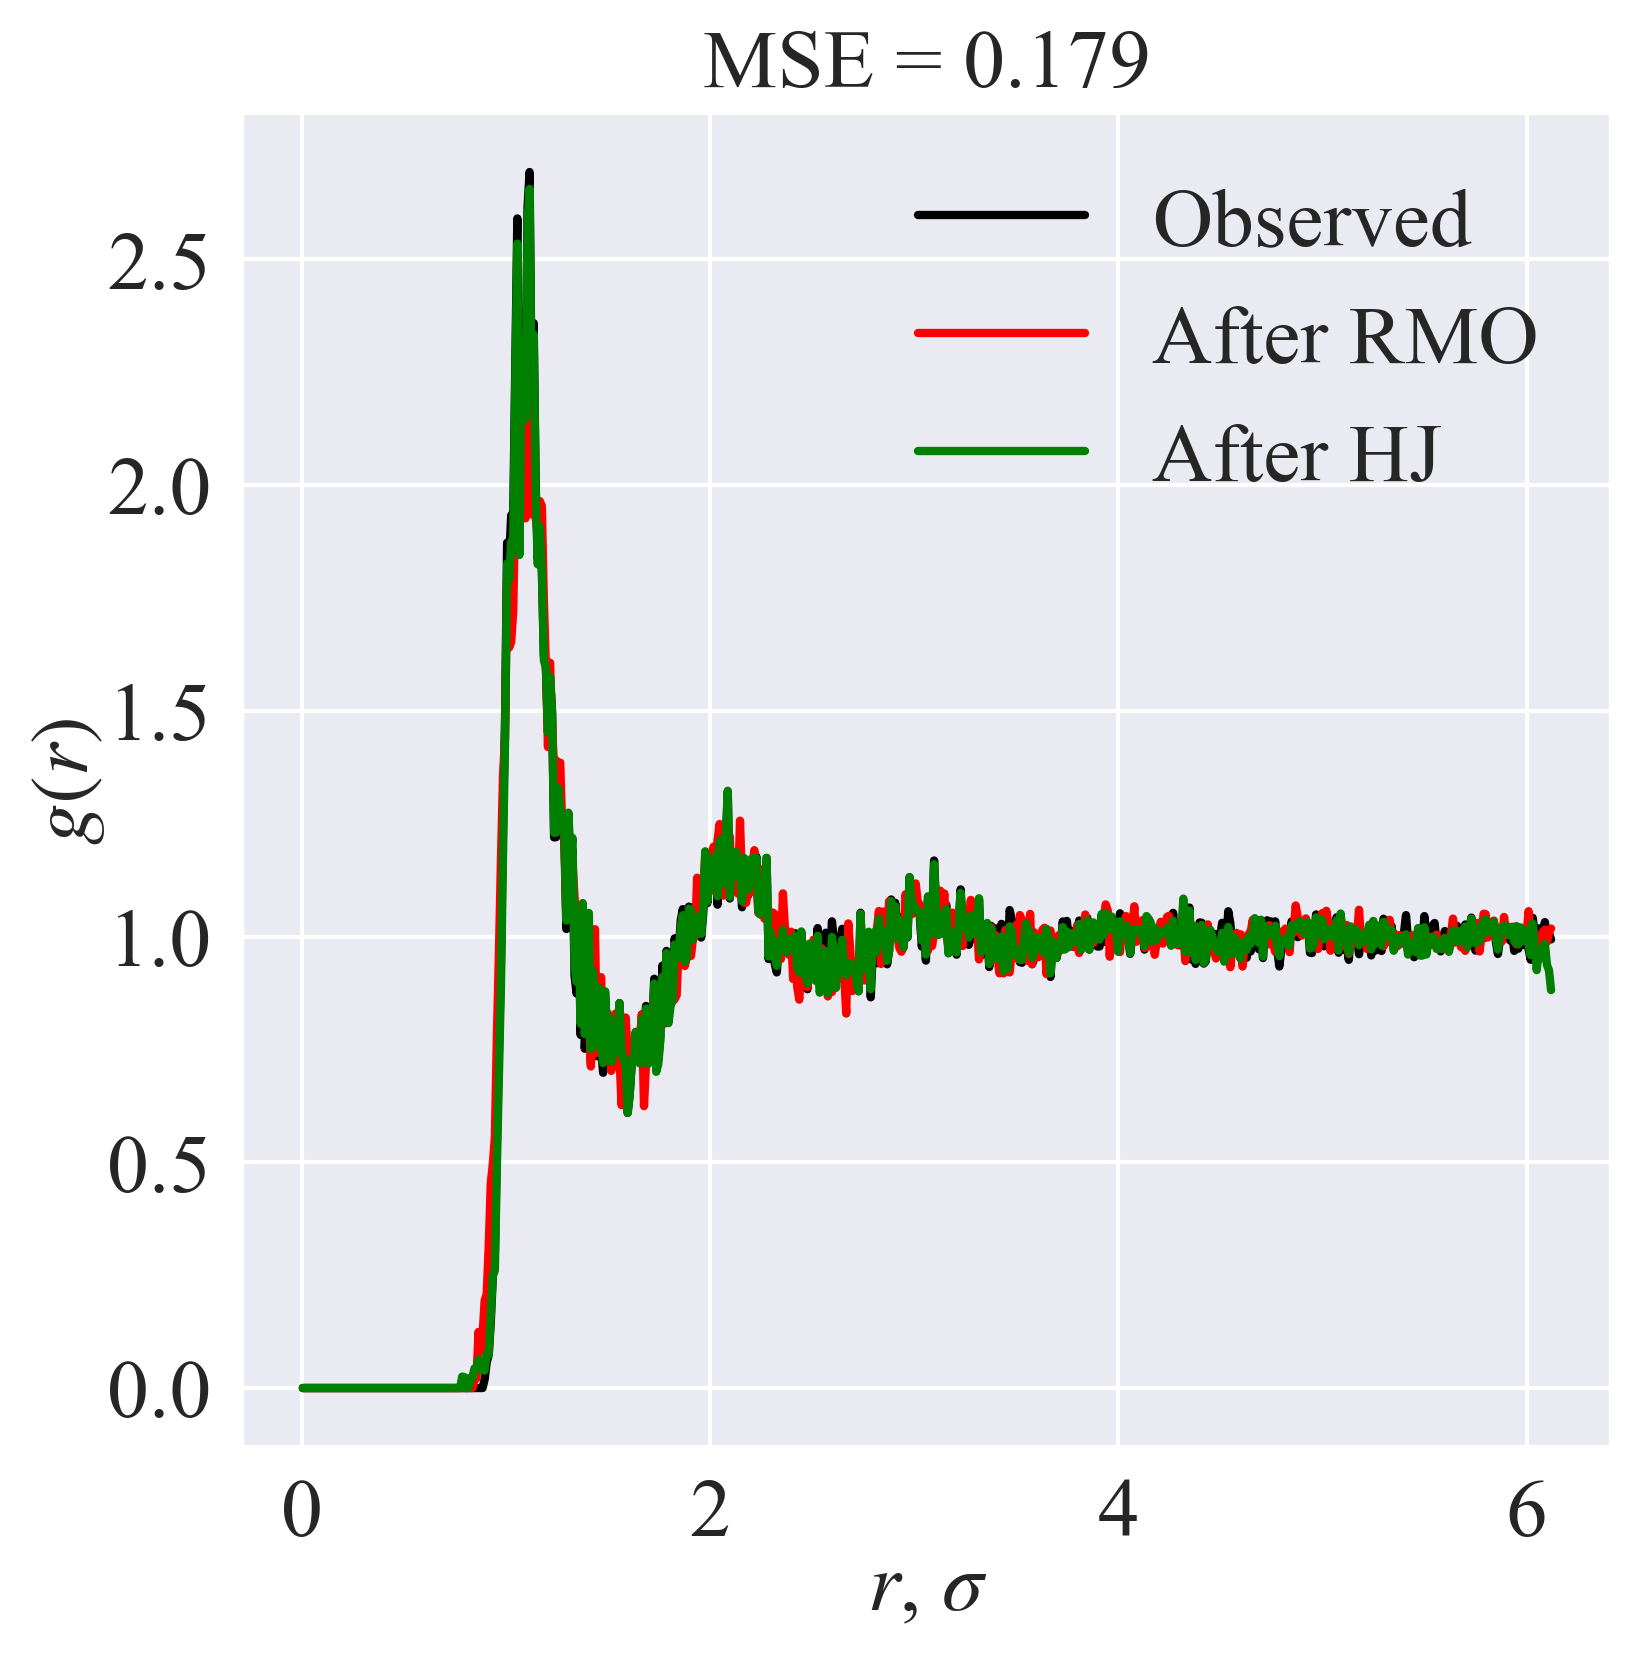

In [29]:
plotter = Plotter(
    path_to_plots=PATH_TO_PLOTS,
    labels=('radius', 'rdf'),
)
plotter.ax.plot(radii, obs_rdf, color='black', label='Observed')
plotter.ax.plot(radii, new_exp_rdf, color='red', label='After RMO')
plotter.ax.plot(radii, new_exp_rdf_hj, color='green', label='After HJ')
plotter.set_title(f'MSE = {mse(obs=obs_rdf, exp=new_exp_rdf_hj):.3f}')
plotter.get_legend()
plotter.save_plot('optimized_state_rmo_hj.png')
plt.show()

In [30]:
cell_dimensions = np.ones(3) * 12.25
ovito_1 = OvitoProcessor(positions=some_positions, cell_dimensions=cell_dimensions)
ovito_2 = OvitoProcessor(positions=new_positions_hj, cell_dimensions=cell_dimensions)

In [31]:
indices_1 = get_unique_frame(ovito_1.get_voronoi_indices())
indices_2 = get_unique_frame(ovito_2.get_voronoi_indices())
for i in range(10):
    if i not in indices_1.columns:
        indices_1[i] = 0
    if i not in indices_2.columns:
        indices_2[i] = 0
merged_indices = indices_1.merge(
    right=indices_2, 
    on=list(range(10)), 
    how='outer',
).fillna(0).astype(int)
merged_indices['diff'] = merged_indices['counts_y'] - merged_indices['counts_x']
merged_indices

,counts_x,0,1,2,3,4,5,6,7,8,9,counts_y,diff
0,17,0,0,1,4,5,3,0,0,0,0,12,-5
1,14,0,0,1,3,5,4,0,0,0,0,10,-4
2,11,0,0,0,3,6,3,0,0,0,0,6,-5
3,11,0,0,0,4,6,2,0,0,0,0,10,-1
4,11,0,0,0,3,6,4,0,0,0,0,2,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,0,0,0,1,7,1,5,1,0,0,0,1,1
1364,0,0,0,1,7,1,7,2,0,0,0,1,1
1365,0,0,0,1,7,2,3,1,1,0,0,1,1
1366,0,0,0,1,7,2,4,1,0,0,0,1,1


In [32]:
volumes_1 = get_unique_frame(ovito_1.get_voronoi_volumes()).rename(columns={0: 'volume'})
volumes_2 = get_unique_frame(ovito_2.get_voronoi_volumes()).rename(columns={0: 'volume'})
merged_volumes = volumes_1.merge(
    right=volumes_2, 
    on='volume', 
    how='outer',
).fillna(0)
merged_volumes['diff'] = merged_volumes['counts_y'] - merged_volumes['counts_x']
merged_volumes

,counts_x,volume,counts_y,diff
0,1.0,0.922137,0.0,-1.0
1,1.0,1.388285,0.0,-1.0
2,1.0,1.390084,0.0,-1.0
3,1.0,1.389975,0.0,-1.0
4,1.0,1.389873,0.0,-1.0
...,...,...,...,...
2739,0.0,1.260101,1.0,1.0
2740,0.0,1.259789,1.0,1.0
2741,0.0,1.259777,1.0,1.0
2742,0.0,1.259382,1.0,1.0


In [33]:
coordinations_1 = get_unique_frame(ovito_1.get_voronoi_coordination()).rename(columns={0: 'coordination'})
coordinations_2 = get_unique_frame(ovito_2.get_voronoi_coordination()).rename(columns={0: 'coordination'})
merged_coordinations = coordinations_1.merge(
    right=coordinations_2, 
    on='coordination', 
    how='outer',
).fillna(0).astype(int)
merged_coordinations['diff'] = merged_coordinations['counts_y'] - merged_coordinations['counts_x']
merged_coordinations

,counts_x,coordination,counts_y,diff
0,339,14,342,3
1,322,13,323,1
2,250,15,254,4
3,176,12,187,11
4,136,16,133,-3
5,76,11,66,-10
6,56,17,44,-12
7,10,18,14,4
8,5,10,7,2
9,2,19,0,-2


In [34]:
merged_indices = merged_indices[
    (merged_indices['counts_x'] > 1)
    & (merged_indices['counts_y'] > 1)
].reset_index(drop=True)
merged_indices

,counts_x,0,1,2,3,4,5,6,7,8,9,counts_y,diff
0,17,0,0,1,4,5,3,0,0,0,0,12,-5
1,14,0,0,1,3,5,4,0,0,0,0,10,-4
2,11,0,0,0,3,6,3,0,0,0,0,6,-5
3,11,0,0,0,4,6,2,0,0,0,0,10,-1
4,11,0,0,0,3,6,4,0,0,0,0,2,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2,0,0,0,3,8,1,0,0,0,0,3,1
117,2,0,0,1,3,4,4,1,0,0,0,7,5
118,2,0,0,1,3,6,1,1,0,0,0,4,2
119,2,0,0,0,3,6,2,0,0,0,0,5,3


In [35]:
merged_indices['diff'].describe()

count    121.000000
mean      -0.338843
std        2.282373
min       -9.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        7.000000
Name: diff, dtype: float64

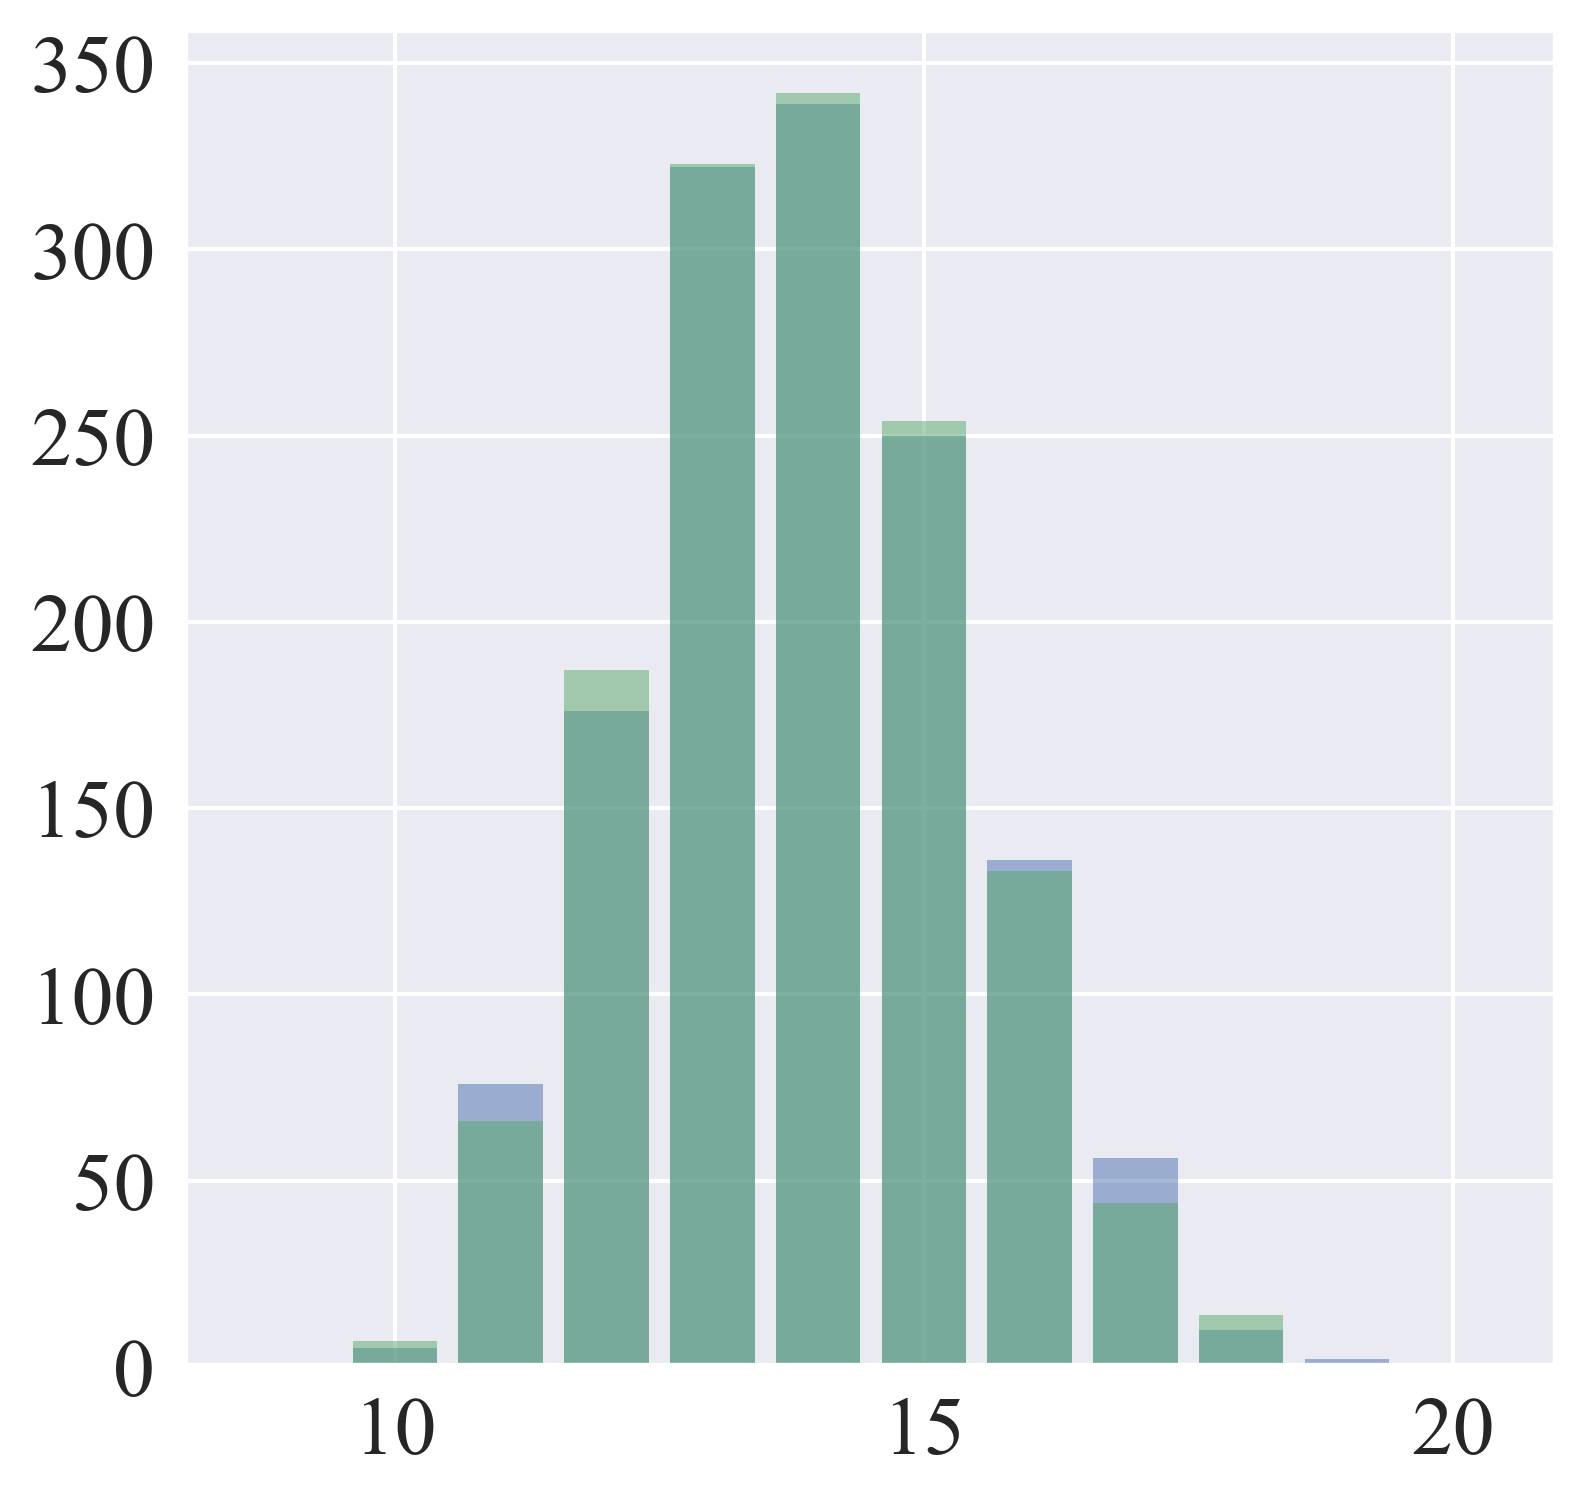

In [36]:
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_x'], alpha=0.5)
plt.bar(merged_coordinations['coordination'], merged_coordinations['counts_y'], alpha=0.5)
plt.show()

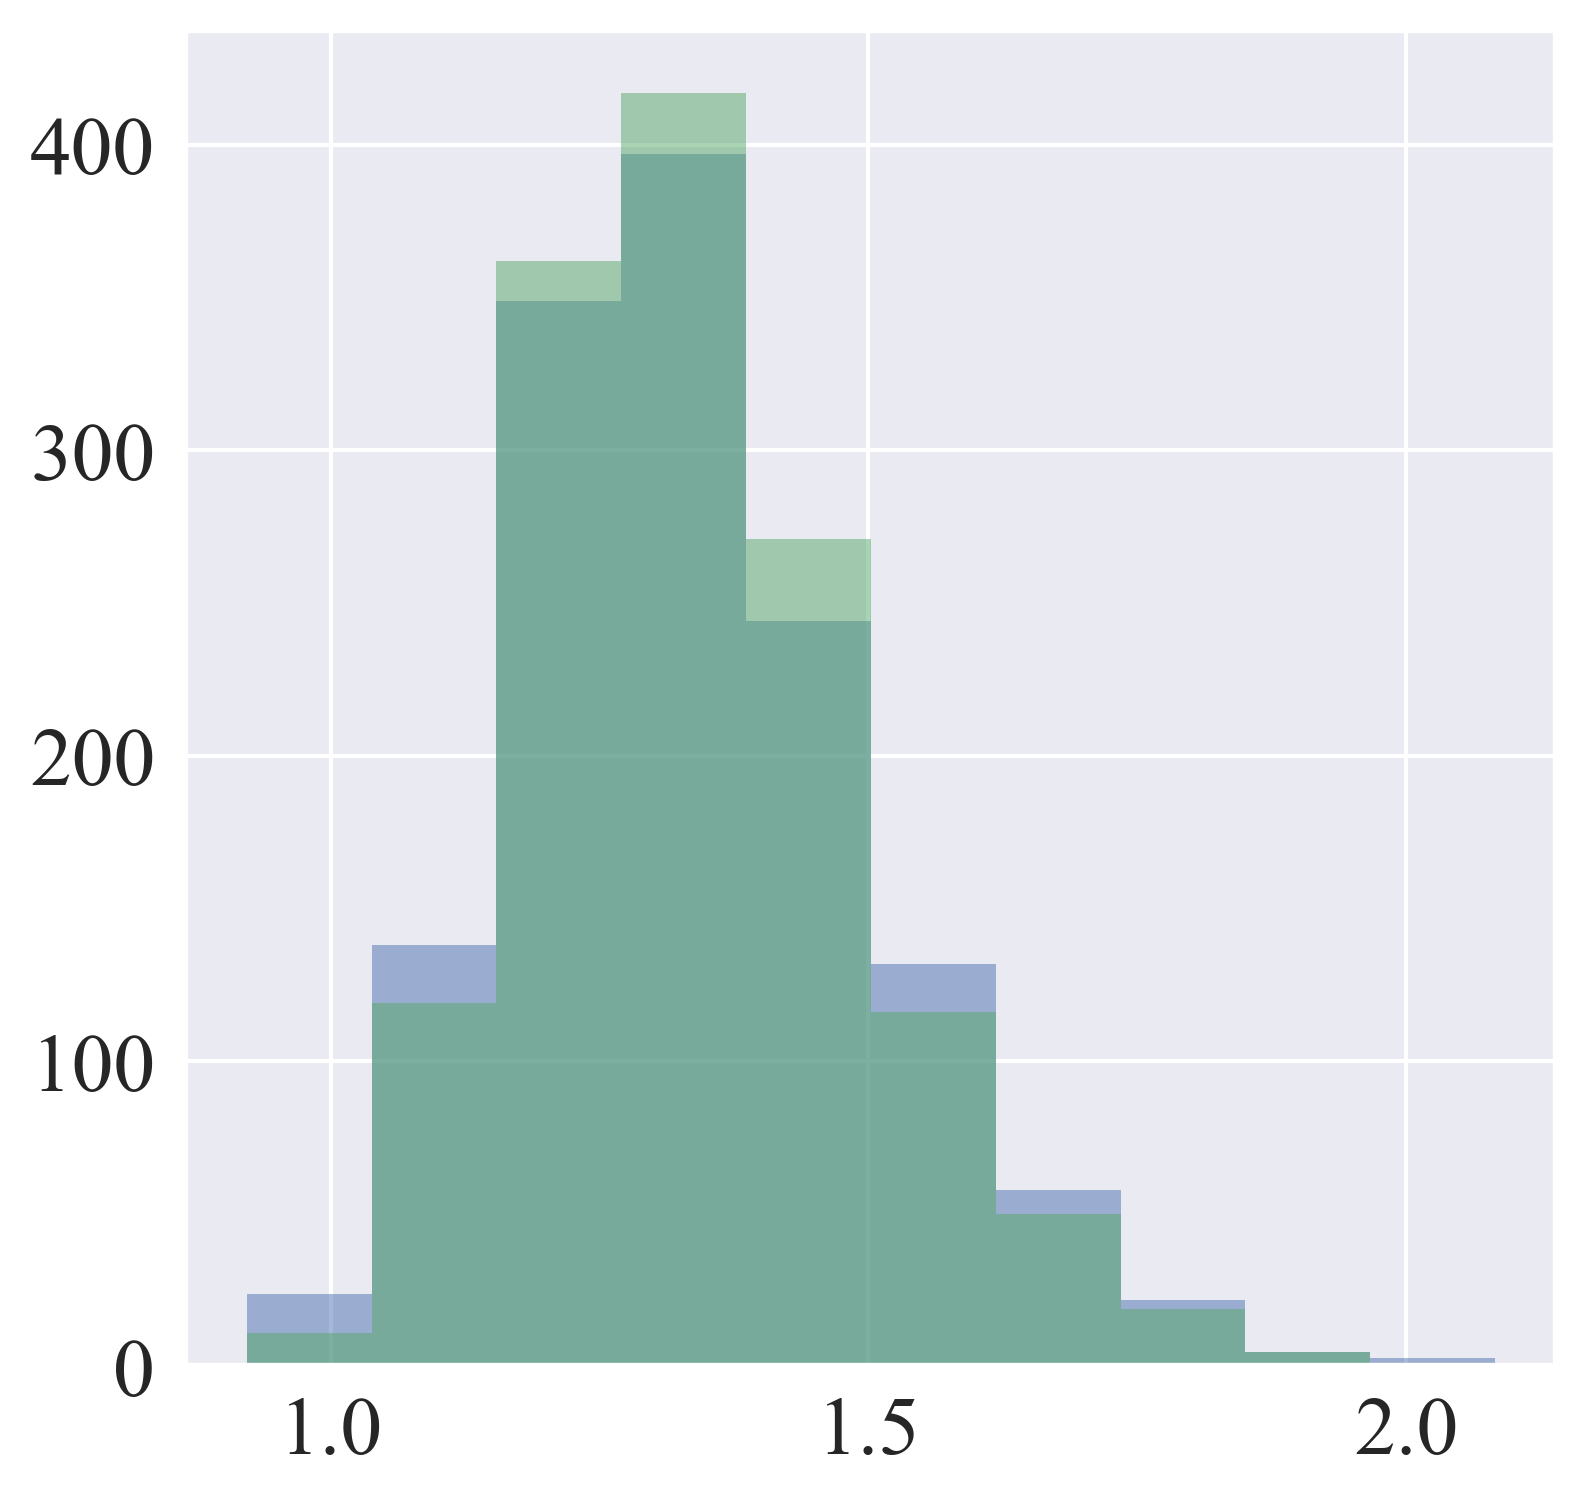

In [37]:
hist, bins, _ = plt.hist(volumes_1['volume'], alpha=0.5)
plt.hist(volumes_2['volume'], alpha=0.5, bins=bins)
plt.show()

In [38]:
radii, ovito_rdf_1, coordination_1 = ovito_1.get_rdf(is_coordination_returned=True)
radii, ovito_rdf_2, coordination_2 = ovito_2.get_rdf(is_coordination_returned=True)

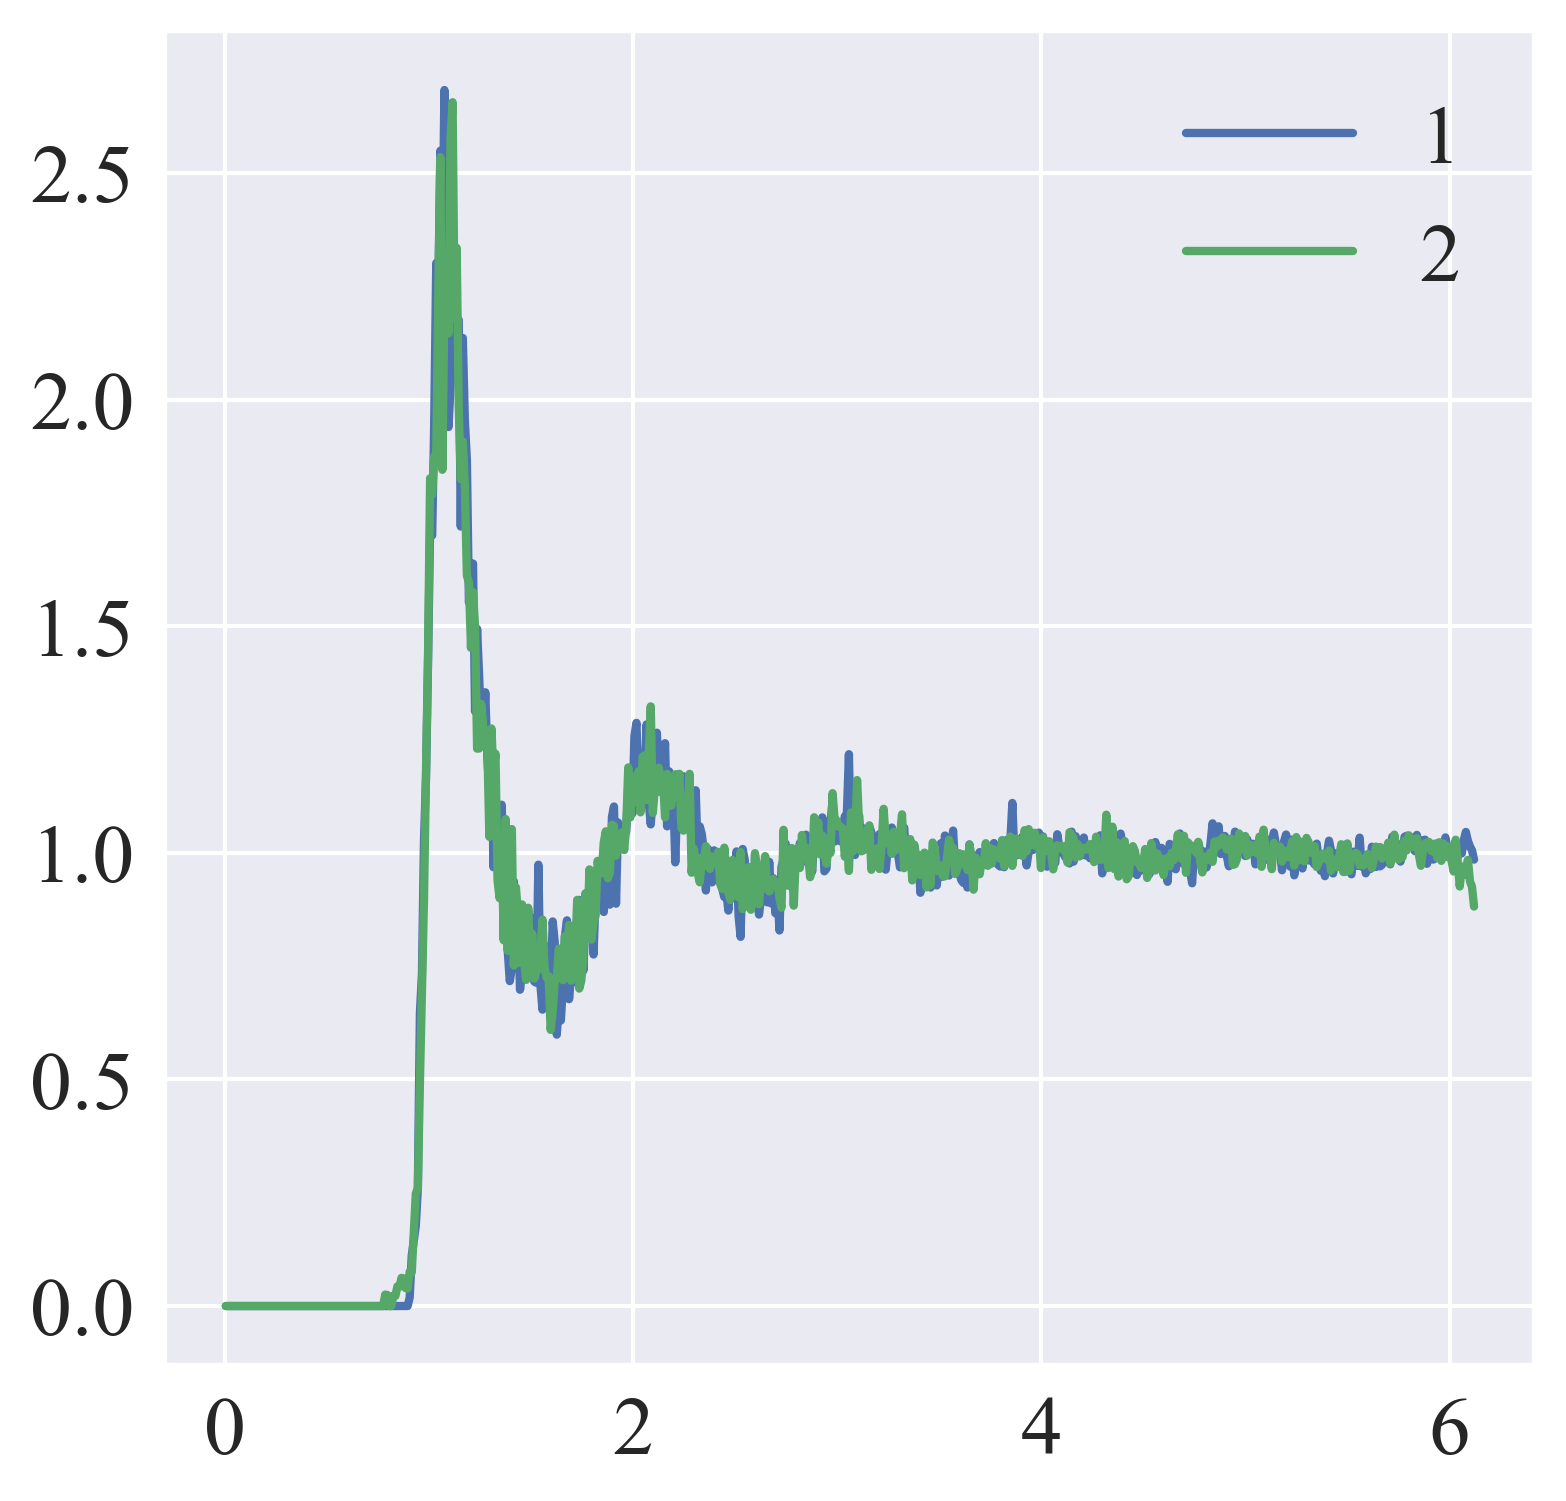

In [39]:
plt.plot(radii, ovito_rdf_1, label='1')
plt.plot(radii, ovito_rdf_2, label='2')
plt.legend()
plt.show()

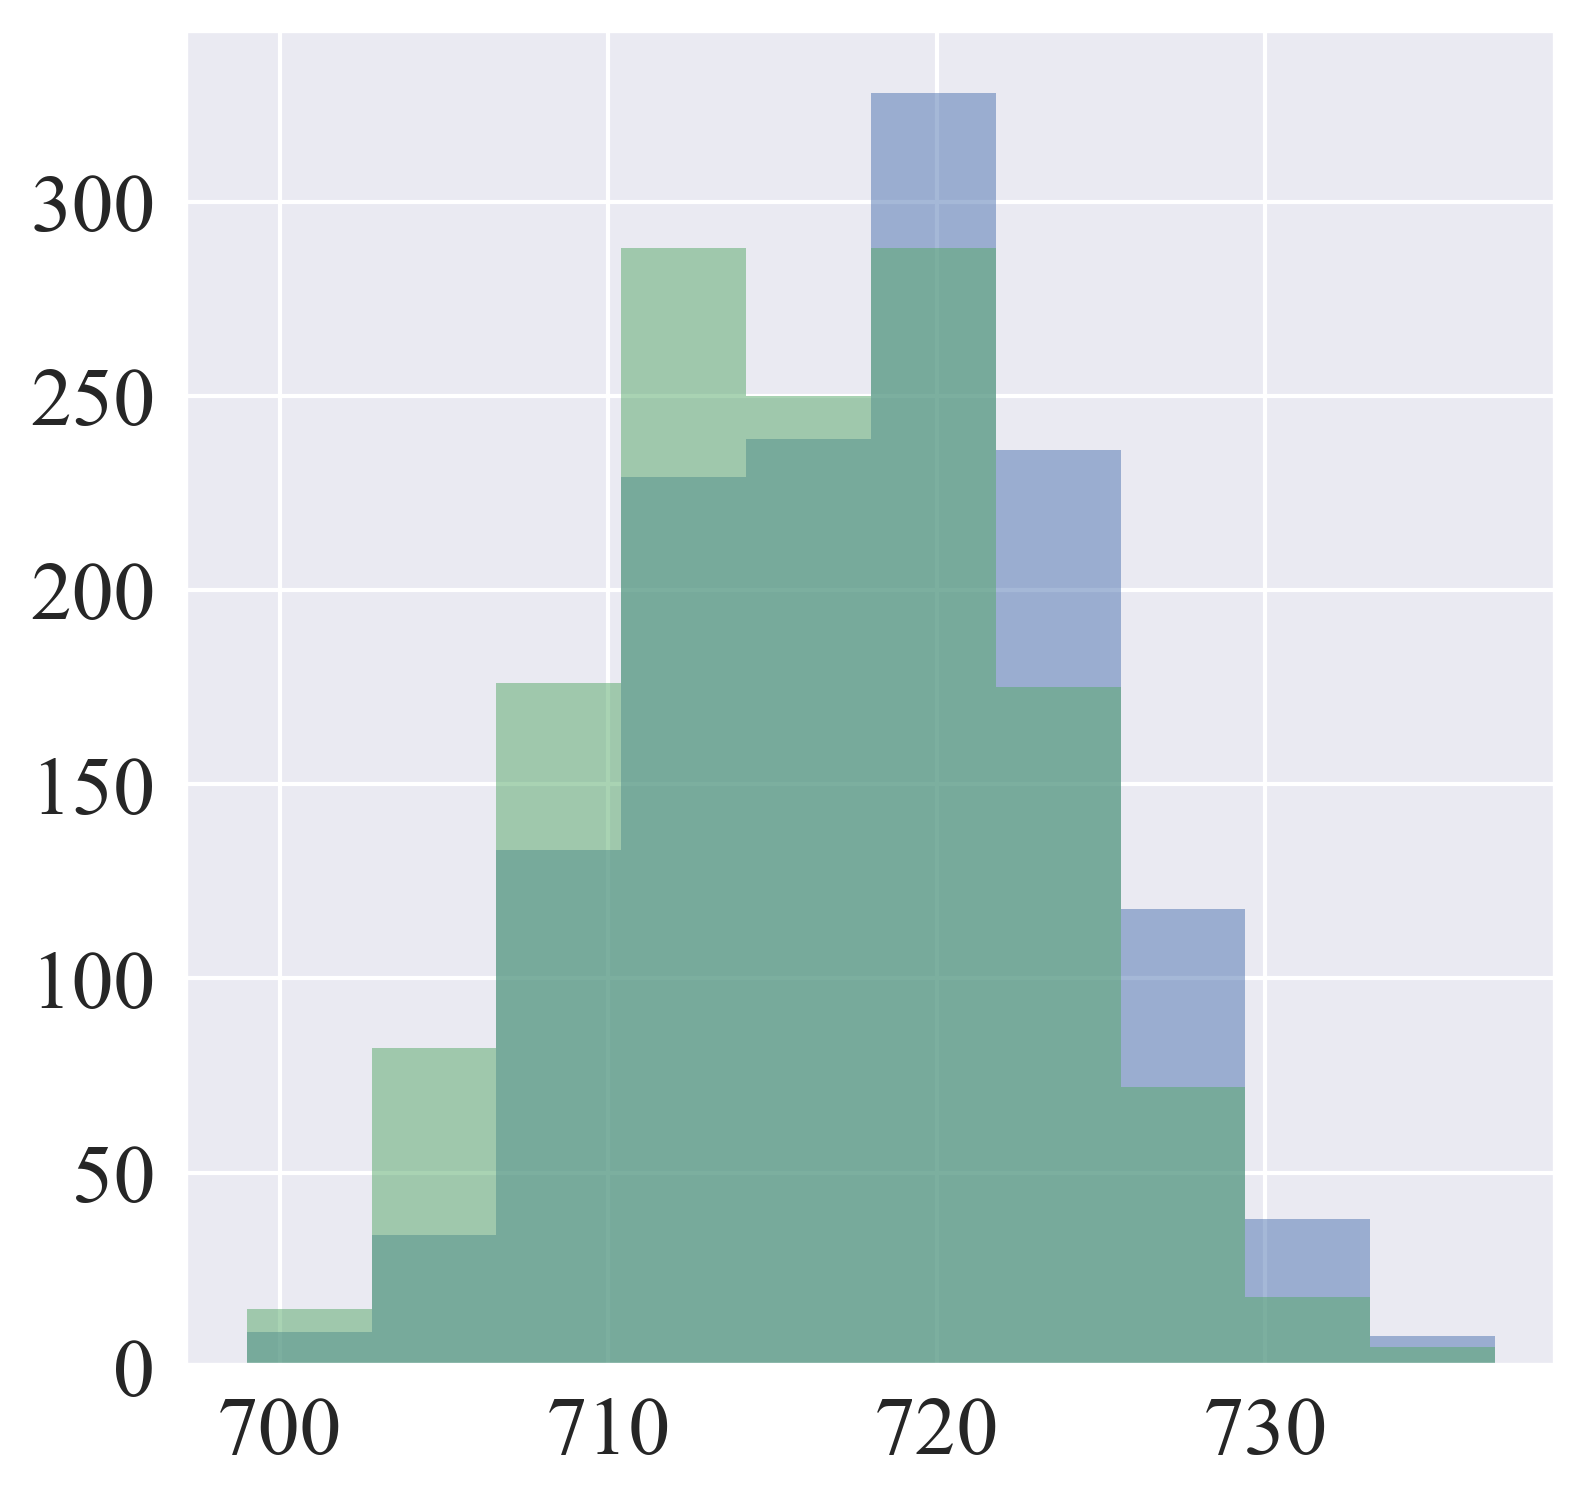

In [40]:
hist, bins, _ = plt.hist(coordination_1, alpha=0.5)
plt.hist(coordination_2, alpha=0.5, bins=bins)
plt.show()